# Homework Assignment 7 - Chem 277B
## Neural Networks and Deep Learning

### 1) Objective

The goal is to perform different regression and classification tasks using neural networks and to compare the performance to standard tools such as linear regression. In order to understand how an ANN actually works, we want to use our custom layers (see lecture) for the analysis.<br>
**Note:** in order to create your ANN efficiently, you can follow the structure provided in the lecture material (ANNI.ipynb, ANNII.ipynb and ANNIII.ipynb)

### 2) Preparation

Before starting, import the necessary libraries for data analysis and visualization. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.datasets import make_moons
from statsmodels.api import add_constant, OLS, Logit, GLM, families, stats

Next, we define our custom layers, such as the dense layer, activation functions and finally an optimizer and a loss function. 

In [2]:
class Layer_Dense():
    
    def __init__(self, n_inputs, n_neurons):
        self.weights = np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
        
    def forward(self, inputs):
        self.output = np.dot(inputs, self.weights) + self.biases
        self.inputs = inputs

    def backward(self, dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        self.dinputs = np.dot(dvalues, self.weights.T)

class Activation_Step():

    def forward(self, inputs):
        self.output = (inputs >= 0).astype(float)
        self.inputs = inputs

    def backward(self, dvalues):
        self.dinputs = np.zeros_like(dvalues)

class Activation_ReLU():

    def forward(self, inputs):
        self.output = np.maximum(0, inputs)
        self.inputs = inputs

    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0

class Activation_Sigmoid():
        
    def forward(self, inputs):
        self.output = np.clip(1 / (1 + np.exp(-inputs)), 1e-7, 1 - 1e-7)

    def backward(self, dvalues):
        sigm = self.output
        deriv = sigm * (1 - sigm)
        self.dinputs = deriv * dvalues

class Activation_Softmax():

    def forward(self, inputs):
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        self.output = probabilities

    def backward(self, dvalues):
        # self.dinputs = np.empty_like(dvalues)
        # for index, (single_output, single_dvalues) in enumerate(zip(self.output, dvalues)):
        #     single_output = single_output.reshape(-1, 1)
        #     jacobian_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T)
        #     self.dinputs[index] = np.dot(jacobian_matrix, single_dvalues)
        jacobian_matrices = (
            np.einsum('ij,jk->ijk', self.output, np.eye(self.output.shape[1]))
            - np.einsum('ij,ik->ijk', self.output, self.output)
        )
        self.dinputs = np.einsum('ijk,ik->ij', jacobian_matrices, dvalues)

class Optimizer_SGD:

    def __init__(self, learning_rate = 0.01):
        self.learning_rate = learning_rate
        
    def update_params(self, layer):
        weight_updates = -self.learning_rate * layer.dweights
        bias_updates = -self.learning_rate * layer.dbiases

        layer.weights += weight_updates
        layer.biases += bias_updates

class Loss_MeanSquaredError:

    def forward(self, y_pred, y_true):
        assert y_pred.shape == y_true.shape, "Shapes of predicted and true values must match."
        return np.mean((y_pred - y_true) ** 2)

    def backward(self, dvalues, y_true):
        Nsamples = len(dvalues)
        self.dinputs = 2 * (dvalues - y_true) / Nsamples

class Loss_BinaryCrossEntropy:

    def forward(self, y_pred, y_true):
        assert y_pred.shape == y_true.shape, "Shapes of predicted and true values must match."
        correct_confidences = y_pred * y_true + (1 - y_pred) * (1 - y_true)
        negative_log_likelihoods = -np.log(correct_confidences)
        return np.mean(negative_log_likelihoods)
    
    def backward(self, dvalues, y_true):
        Nsamples = len(dvalues)
        self.dinputs = - (y_true / dvalues - (1 - y_true) / (1 - dvalues)) / Nsamples

class Loss_MultiClassCrossEntropy:

    def forward(self, y_pred, y_true):
        assert y_pred.shape == y_true.shape, "Shapes of predicted and true values must match."
        correct_confidences = np.sum(y_pred * y_true, axis=1)
        negative_log_likelihoods = -np.log(correct_confidences)
        return np.mean(negative_log_likelihoods)
    
    def backward(self, dvalues, y_true):
        Nsamples = len(dvalues)
        self.dinputs = - (y_true / dvalues) / Nsamples

### 3) Regression Task

#### 3.1) Data Generation

First, we will perform a regression task using a neural network on a synthetic dataset generated from an exponential function with added noise.

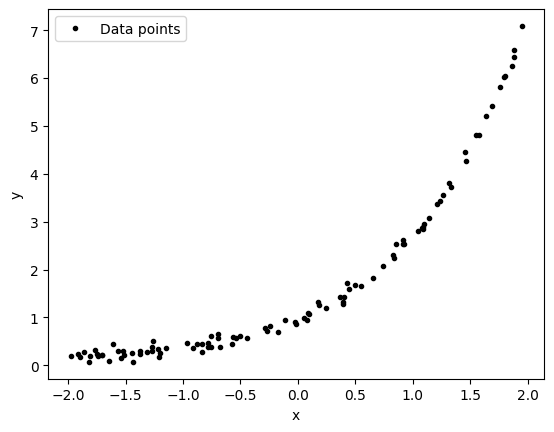

In [3]:
np.random.seed(42)

x = np.random.uniform(-2, 2, (100, 1))
y = np.exp(x) + 0.1 * np.random.randn(len(x), 1)

plt.plot(x, y, 'k.', label='Data points')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

#### 3.2) Linear Model

Without using a neural network, fit a linear regression model to the data and visualize the results. For that purpose, you can use a single dense layer without activation as the model (**recall: the neuron itself is just a linear model**), and use the gradient descent to minimize the mean squared error. Plot the original data points and the model predictions. Discuss the performance of the linear regression model.

Epoch 0, Loss: 4.470743
Epoch 50, Loss: 0.676953
Epoch 100, Loss: 0.676849
Epoch 150, Loss: 0.676849
Epoch 200, Loss: 0.676849


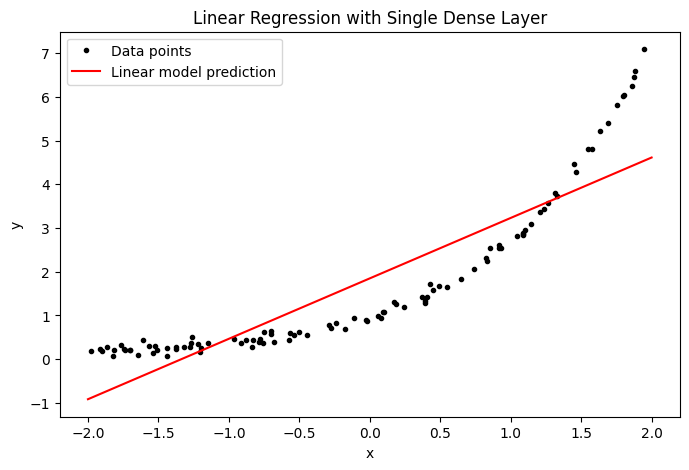

In [4]:
np.random.seed(0)

# model: Dense
dense1 = Layer_Dense(1, 1)  # single neuron, linear model
loss_function = Loss_MeanSquaredError()
optimizer = Optimizer_SGD(learning_rate=0.05)

# training loop
epochs = 201
for epoch in range(epochs):
    # forward pass
    dense1.forward(x)
    y_pred = dense1.output

    # loss
    loss = loss_function.forward(y_pred, y)

    # backward pass
    loss_function.backward(y_pred, y)
    dense1.backward(loss_function.dinputs)

    # update weights
    optimizer.update_params(dense1)

    # print progress
    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.6f}")

# prediction
# create 100 evenly spaced points for plotting a smooth prediction curve
x_line = np.linspace(-2, 2, 100).reshape(-1, 1)
dense1.forward(x_line)
y_line = dense1.output

# plot results
plt.figure(figsize=(8, 5))
plt.plot(x, y, 'k.', label='Data points')
plt.plot(x_line, y_line, 'r-', label='Linear model prediction')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Linear Regression with Single Dense Layer')
plt.show()

*Discussion*

The linear regression model behaved as expected.
It quickly reduced error, then plateaued at a loss of ~0.68.

This shows the optimizer found the best straight-line fit, but since the true relationship is exponential, the model underfits, capturing only the average slope and missing the curvature.

A useful baseline, however highlights the need for nonlinear activations and deeper networks to model more complex functions.

Some of the early activation functions, like a linear function or a Heaviside step function, are not used in modern neural networks. Explain why these activation functions are not suitable for training deep neural networks.

*Discussion*

Early activation functions like the linear and Heaviside step functions are unsuitable for deep networks because they lack the nonlinearity and gradients needed for learning. A linear activation collapses stacked layers into a single linear mapping, preventing the model from capturing complex patterns. The step function outputs only 0 or 1, with a derivative that is zero almost everywhere, making backpropagation ineffective. As a result, neither function supports effective training in modern neural networks.


#### 3.3) Single Neuron

Use a single neuron to fit the same data. Again, train the network using gradient descent to minimize the mean squared error, and plot the original data points and the model predictions. Compare the performance of the single neuron model with that of the linear regression model.

Hint: You need a linear layer to scale the input of the neuron, an activation function (e.g., ReLU, which I recommend for its simplicity and effectiveness), and another linear layer to scale the output of the neuron.

Epoch 0, Loss: 3.794934
Epoch 50, Loss: 0.122671
Epoch 100, Loss: 0.116895
Epoch 150, Loss: 0.114773
Epoch 200, Loss: 0.114317
Epoch 250, Loss: 0.113671
Epoch 300, Loss: 0.113445
Epoch 350, Loss: 0.112250
Epoch 400, Loss: 0.110336
Epoch 450, Loss: 0.109859
Epoch 500, Loss: 0.109747
Epoch 550, Loss: 0.109722
Epoch 600, Loss: 0.109717
Epoch 650, Loss: 0.109716
Epoch 700, Loss: 0.109715
Epoch 750, Loss: 0.109715
Epoch 800, Loss: 0.109715


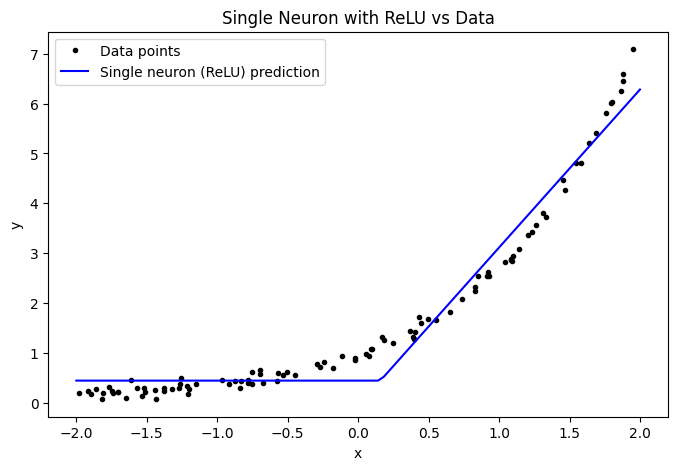

In [5]:
np.random.seed(0)

# model: Dense -> ReLU -> Dense
dense1 = Layer_Dense(1, 1)   # input to hidden
activation1 = Activation_ReLU()
dense2 = Layer_Dense(1, 1)   # hidden to output

loss_function = Loss_MeanSquaredError()
optimizer = Optimizer_SGD(learning_rate=0.05)

# training loop
epochs = 801
for epoch in range(epochs):
    # forward pass
    dense1.forward(x)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    y_pred = dense2.output

    # loss
    loss = loss_function.forward(y_pred, y)

    # backward pass
    loss_function.backward(y_pred, y)
    dense2.backward(loss_function.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    # update weights
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)

    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.6f}")

# predictions
# create 100 evenly spaced points for plotting a smooth prediction curve
x_line = np.linspace(-2, 2, 100).reshape(-1, 1)
dense1.forward(x_line)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
y_line = dense2.output

# plot results
plt.figure(figsize=(8, 5))
plt.plot(x, y, 'k.', label='Data points')
plt.plot(x_line, y_line, 'b-', label='Single neuron (ReLU) prediction')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Single Neuron with ReLU vs Data')
plt.show()

*Discussion*

##### Linear Regression (Single Dense Layer, No Activation)

The linear regression model, composed of a single dense layer without any activation function, began training with a high initial loss of approximately 4.47.
This loss quickly decreased in the early epochs but plateaued around **0.677**, indicating that the model had reached the limits of its capacity.
While it successfully identified the best straight-line approximation to the data, it could only capture the average slope of the underlying exponential relationship.
Because the model is purely linear, it lacks the flexibility to represent nonlinear patterns, resulting in underfitting and limited predictive performance.

---

##### Single Neuron with ReLU (Dense $\rightarrow$ ReLU $\rightarrow$  Dense)


In contrast, the single-neuron model with a ReLU activation, structured as a dense layer followed by ReLU and another dense layer, started with a slightly lower initial loss of around 3.79.
Over the course of training, the loss steadily declined and ultimately converged to approximately **0.11**.
The inclusion of the ReLU activation introduced nonlinearity into the model, enabling it to bend its output and more closely follow the exponential shape of the data.
Somewhat remarkably, even with just one nonlinear activation, the model was able to capture curvature that the linear regression model entirely missed.

---

##### Comparison

While the **linear regression model** is simple and easy to interpret, it is fundamentally limited in its ability to model complex, nonlinear relationships.
Its inability to adapt to the curvature of the data led to underfitting and a relatively high final loss.
On the other hand, the **single-neuron ReLU** model highlights the power of nonlinearity in neural networks.
With only one hidden activation, it achieved a significantly lower loss, roughly **one-sixth** that of the linear model, and produced predictions that aligned much more closely with the true data distribution.
This experiment also underscores that without nonlinear activations, stacking layers would add no additional modeling capacity, and the network would equivalent funciton as a single linear transformation.

---

#### 3.4) Neural Network

Now, use a neural network with 1 hidden layer containing 2 neurons and an appropriate activation function (e.g., ReLU) to fit the same data. Train the model, plot the original data points and the model predictions, and compare the performance with the previous models.

Epoch 0, Loss: 0.361016
Epoch 50, Loss: 0.117292
Epoch 100, Loss: 0.114521
Epoch 150, Loss: 0.108891
Epoch 200, Loss: 0.098638
Epoch 250, Loss: 0.082747
Epoch 300, Loss: 0.070943
Epoch 350, Loss: 0.057358
Epoch 400, Loss: 0.044989
Epoch 450, Loss: 0.036965
Epoch 500, Loss: 0.032040
Epoch 550, Loss: 0.029507
Epoch 600, Loss: 0.027856
Epoch 650, Loss: 0.026957
Epoch 700, Loss: 0.026576
Epoch 750, Loss: 0.026416
Epoch 800, Loss: 0.026349
Epoch 850, Loss: 0.026321
Epoch 900, Loss: 0.026309
Epoch 950, Loss: 0.026304
Epoch 1000, Loss: 0.026302
Epoch 1050, Loss: 0.026301
Epoch 1100, Loss: 0.026301


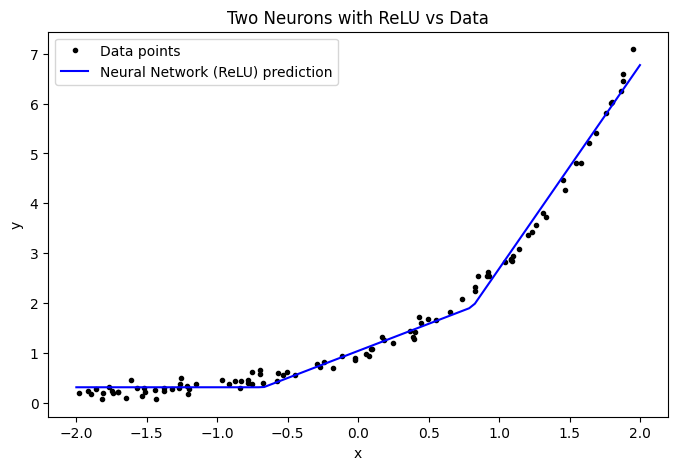

In [6]:
np.random.seed(0)

# model: Dense -> ReLU -> Dense
dense1 = Layer_Dense(1, 2)   # input to hidden
activation1 = Activation_ReLU()
dense2 = Layer_Dense(2, 1)   # hidden to output

loss_function = Loss_MeanSquaredError()
optimizer = Optimizer_SGD(learning_rate=0.05)

# training loop
epochs = 1101
for epoch in range(epochs):
    # forward pass
    dense1.forward(x)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    y_pred = dense2.output

    # loss
    loss = loss_function.forward(y_pred, y)

    # backward pass
    loss_function.backward(y_pred, y)
    dense2.backward(loss_function.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    # update weights
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)

    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.6f}")

# predictions
# create 100 evenly spaced points for plotting a smooth prediction curve
x_line = np.linspace(-2, 2, 100).reshape(-1, 1)
dense1.forward(x_line)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
y_line = dense2.output

# plot results
plt.figure(figsize=(8, 5))
plt.plot(x, y, 'k.', label='Data points')
plt.plot(x_line, y_line, 'b-', label='Neural Network (ReLU) prediction')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Two Neurons with ReLU vs Data')
plt.show()

*Discussion*

##### Neural Network with 2 Hidden Neurons (Dense $\rightarrow$ ReLU $\rightarrow$  Dense)

The neural network with one hidden layer containing two neurons and a ReLU activation showed a significant improvement in performance over both the linear regression model and the single-neuron ReLU model.
Training began with a loss of approximately 0.36 and steadily decreased over 1100 epochs, ultimately converging to a final loss of about **0.0263**, roughly **one-quarter** the loss of the single neuron model.
The steady decline in loss also indicates that the model was able to learn a much more accurate representation of the underlying exponential function.

With two hidden neurons, the network gained additional flexibility to model nonlinear patterns.
The ReLU activation allowed each neuron to respond selectively to different regions of the input space, and the combination of their outputs enabled the network to approximate the exponential curve with much greater precision.
The resulting predictions closely followed the curvature of the data, outperforming both previous models in terms of fit quality and error reduction.

#### 3.5) Universal Approximation Theorem

According to the universal approximation theorem, a neural network with a single hidden layer containing a sufficient number of neurons can approximate any continuous function. Try a large number of neurons (e.g., 128 or 1024) in the hidden layer, and see how well the model fits the data. Discuss your observations. Does the theory hold in practice? If not, what could be the reasons and possible solutions? 

Hint: You don't need to implement the solutions, just discuss them. Or you can try them if you want in Question 6 afterwards.

Epoch 0, Loss: 734.658532
Epoch 1000, Loss: 0.042423
Epoch 2000, Loss: 0.025568
Epoch 3000, Loss: 0.018473
Epoch 4000, Loss: 0.015078
Epoch 5000, Loss: 0.013073
Epoch 6000, Loss: 0.012000
Epoch 7000, Loss: 0.011399
Epoch 8000, Loss: 0.011071
Epoch 9000, Loss: 0.010824
Epoch 10000, Loss: 0.010624
Epoch 11000, Loss: 0.010465


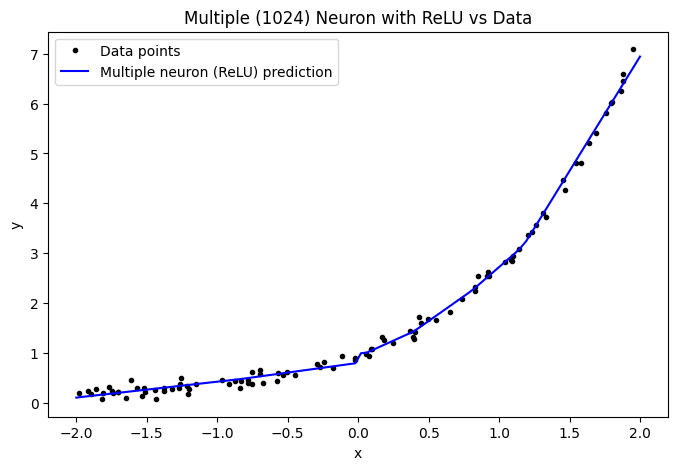

In [7]:
np.random.seed(0)

# model: Dense -> ReLU -> Dense
N_neurons = 1024
dense1 = Layer_Dense(1, N_neurons)   # input to hidden
activation1 = Activation_ReLU()
dense2 = Layer_Dense(N_neurons, 1)   # hidden to output

loss_function = Loss_MeanSquaredError()
optimizer = Optimizer_SGD(learning_rate=0.0005)

# training loop
epochs = 11001
for epoch in range(epochs):
    # forward pass
    dense1.forward(x)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    y_pred = dense2.output

    # loss
    loss = loss_function.forward(y_pred, y)

    # backward pass
    loss_function.backward(y_pred, y)
    dense2.backward(loss_function.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    # update weights
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.6f}")

# predictions
# create 100 evenly spaced points for plotting a smooth prediction curve
x_line = np.linspace(-2, 2, 100).reshape(-1, 1)
dense1.forward(x_line)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
y_line = dense2.output

# plot results
plt.figure(figsize=(8, 5))
plt.plot(x, y, 'k.', label='Data points')
plt.plot(x_line, y_line, 'b-', label='Multiple neuron (ReLU) prediction')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title(f'Multiple ({N_neurons}) Neuron with ReLU vs Data')
plt.show()

*Discussion*

Initially, we encountered issues with numerical stability and overflow when training networks with larger hidden layers.
To address these problems, we reduced the learning rate while we might have also normalized the input variable **x** to have zero mean and unit variance.
These adjustments help stabilize training and allowed us to explore the behavior of wider networks.
Also, we can we that with a large number (1024) of neurons we start to see overfitting (see discontinuity at $x=0$). 

##### Neural Network with a Large Hidden Layer (1024 Neurons)

According to the universal approximation theorem, a feedforward neural network with a single hidden layer containing a sufficient number of neurons and a nonlinear activation function (such as ReLU) may approximate any continuous function on a compact domain.
This theoretical result suggests that, in principle, increasing the number of neurons should allow the network to fit the exponential data with arbitrary precision.

When increasing the hidden layer size 1024 neurons, the model generally achieved a much lower loss and produced predictions that closely followed the exponential curve.
The fit became smoother and more accurate, especially in regions where smaller models struggled.
These results confirm that the network had enough capacity to represent the target function.
However, it seems that the outcomes did not always align perfectly with the theory.
In practice, we observed slower convergence (mainly due to the lower learning-rate), occasional instability during training, and the risk of overfitting when the model began to memorize noise rather than generalize.
Beyond a certain size, adding more neurons also led to diminishing returns, with little improvement in performance despite the increase in capacity.

##### Does the Theory Hold in Practice?

The universal approximation theorem guarantees the existence of a solution but does not ensure that gradient descent will find it efficiently.
In practice, several factors (see: *Possible Solutions* below) may prevent large networks from achieving optimal performance.
Optimization challenges such as vanishing gradients, poor weight initialization, or overly aggressive learning rates may destabilize training.
Data limitations also play a role, with small or as in our case of noisy datasets, larger models are more likely to overfit.
Computational cost is another consideration, as wider networks require more memory and training time.
Finally, the architecture itself matters, the choice of activation function, initialization scheme, and optimizer may dramatically affect results.

##### Possible Solutions

We considered several strategies that might help mitigate our challenges:

- **Regularization techniques** such as dropout, weight decay, or early stopping to reduce overfitting.  
- **Batch normalization** to stabilize and accelerate training by controlling the distribution of activations.  
- **Improved initialization methods** such as He or Xavier initialization to promote healthier gradient flow.  
- **Adaptive optimizers** like Adam or RMSprop, which often converge more efficiently than a plain stochastic gradient descent.  
- **Smaller, deeper architectures** (autoencoder) instead of one massive hidden layer, which might improve both expressiveness and trainability.

see also:

 - https://www.geeksforgeeks.org/deep-learning/universal-approximation-theorem-for-neural-networks/
 - https://en.wikipedia.org/wiki/Universal_approximation_theorem
 - https://arxiv.org/html/2407.12895v1
 - https://machinecurve.com/index.php/2019/09/16/he-xavier-initialization-activation-functions-choose-wisely

### 4) Binary Classification Task

#### 4.1) Data Generation

The second task is a binary classification problem. Generate the double moon dataset using the provided function.

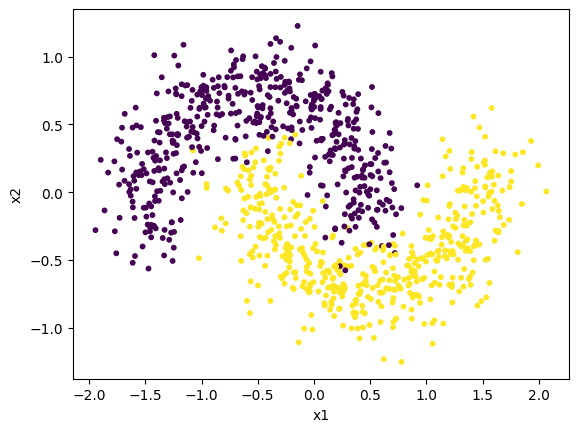

In [8]:
x, y = make_moons(n_samples=1000, noise=0.2, shuffle=True, random_state=42)
x[:, 0] = x[:, 0] - 0.5
x[:, 1] = x[:, 1] - 0.25
y = y.reshape(-1, 1)

plt.scatter(x[:, 0], x[:, 1], c=y, s=10)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

#### 4.2) Linear Model

Using a single dense layer without activation as the model, train the network using gradient descent to minimize the binary cross-entropy loss. Plot the data points and the model predictions. Discuss the performance of the linear model.

Hint: The model should output a single value between 0 and 1 to represent the probability of one of the classes. Use the sigmoid activation function after the dense layer to output probabilities between 0 and 1.

Epoch 0, Loss: 0.5672
Epoch 500, Loss: 0.3523
Epoch 1000, Loss: 0.3104
Epoch 1500, Loss: 0.2970
Epoch 2000, Loss: 0.2914
Epoch 2500, Loss: 0.2887
Epoch 3000, Loss: 0.2873
Epoch 3500, Loss: 0.2866
Epoch 4000, Loss: 0.2861
Epoch 4500, Loss: 0.2859
Epoch 5000, Loss: 0.2857
Epoch 5500, Loss: 0.2856
Epoch 6000, Loss: 0.2856


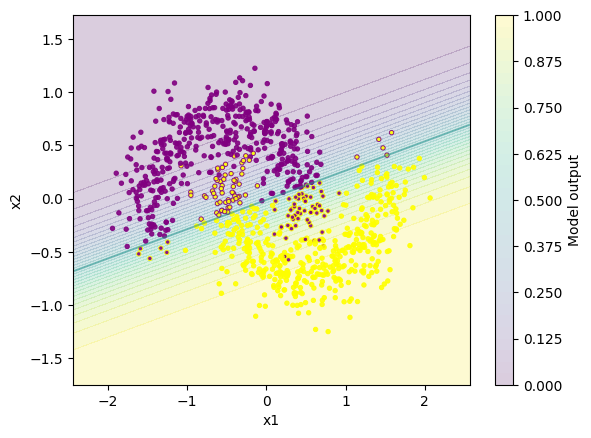

In [9]:
np.random.seed(0)

# model: Dense -> Sigmoid
dense1 = Layer_Dense(2, 1)   # 2D input
activation1 = Activation_Sigmoid()
loss_function = Loss_BinaryCrossEntropy()
optimizer = Optimizer_SGD(learning_rate=0.05)

# training loop
epochs = 6001
for epoch in range(epochs):
    # forward pass
    dense1.forward(x)
    activation1.forward(dense1.output)
    y_pred = activation1.output

    # loss
    loss = loss_function.forward(y_pred, y)

    # backward pass
    loss_function.backward(y_pred, y)
    activation1.backward(loss_function.dinputs)
    dense1.backward(activation1.dinputs)

    # update weights
    optimizer.update_params(dense1)

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")


# decision boundary
xx, yy = np.meshgrid(
    np.linspace(x[:, 0].min() - 0.5, x[:, 0].max() + 0.5, 200),
    np.linspace(x[:, 1].min() - 0.5, x[:, 1].max() + 0.5, 200)
)
grid = np.c_[xx.ravel(), yy.ravel()]

# prediction for decision boundary visualization
dense1.forward(grid)
activation1.forward(dense1.output)
zz = activation1.output.reshape(xx.shape)

# prediction for training data (to color edges) based on probabilities
y_pred_labels = (y_pred > 0.5).astype(int).ravel()
dense1.forward(x)
activation1.forward(dense1.output)
y_pred_train = activation1.output
y_pred_labels = (y_pred_train > 0.5).astype(int).ravel()

# plot true (fill) and predicted (edge) classes
fill_colors = np.where(y.ravel() == 0, 'purple', 'yellow')
edge_colors = np.where(y_pred_labels == 0, 'purple', 'yellow')
plt.scatter(
    x[:, 0], x[:, 1],
    c=fill_colors,        # true class as fill color
    s=10,
    edgecolors=edge_colors, # predicted class as edge color
    linewidths=0.7,
    alpha=0.9
)

# decision boundary visualization
plt.contour(xx, yy, zz, levels=[0, 0.5, 1], alpha=0.5)
plt.contourf(xx, yy, zz, levels=np.linspace(0, 1, 33), alpha=0.2, zorder=-1)
plt.xlabel('x1')
plt.ylabel('x2')
plt.colorbar(label='Model output')
plt.show()

*Discussion*

The visualization highlights both the predictions of the model and its limitations.
The background shading represents the model's probability field, smoothly transitioning from purple to yellow to indicate where it believes class 0 or class 1 is more likely.
The blue contour line at the centermarks the decision boundary at probability 0.5, with points on one side classified as class 0 and those on the other as class 1.
The scatter points provides a direct comparison between truth and prediction with the fill color showing the true class, while the edge color shows the predicted class, thus when they differ, the model has incorrectly classifed the point.

As expected, this produces a straight‑line decision boundary.
Because the double moon dataset is non‑linearly separable, a straight line cannot capture the crescent‑shaped structure of the data.
This is evident in the clusters of points where the fill and edge colors do not match, highlighting regions where the linear model fails.
The training loss decreases and then plateaus, indicating that the model has converged to the best possible linear separation. 

#### 4.3) Neural Network Model

Using a neural network with 1 hidden layer, fit the double moon dataset. How many neurons are needed in the hidden layer? Discuss the performance of the model.

Epoch 0, Loss: 1.0986
Epoch 500, Loss: 0.2541
Epoch 1000, Loss: 0.1880
Epoch 1500, Loss: 0.1489
Epoch 2000, Loss: 0.1258
Epoch 2500, Loss: 0.1120
Epoch 3000, Loss: 0.1025
Epoch 3500, Loss: 0.0956
Epoch 4000, Loss: 0.0906
Epoch 4500, Loss: 0.0867
Epoch 5000, Loss: 0.0836
Epoch 5500, Loss: 0.0810
Epoch 6000, Loss: 0.0790


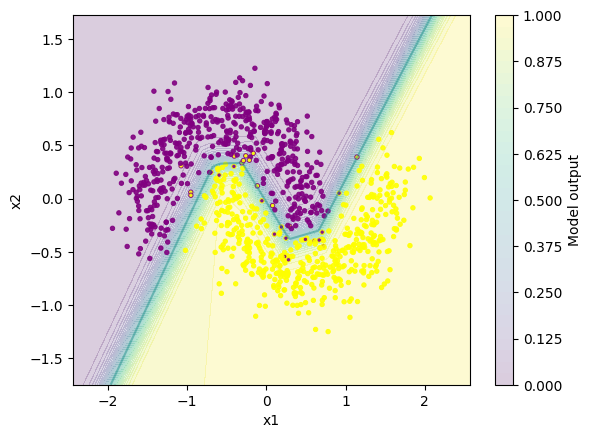

In [10]:
np.random.seed(0)

# model: Dense(2 -> N) -> ReLU -> Dense(N -> 1) -> Sigmoid
N = 8
dense1 = Layer_Dense(2, N)               # hidden layer with 8 neurons
activation1 = Activation_ReLU()
dense2 = Layer_Dense(N, 1)               # output layer
activation2 = Activation_Sigmoid()

# loss and optimizer
loss_function = Loss_BinaryCrossEntropy()
optimizer = Optimizer_SGD(learning_rate=0.05)

# training loop
epochs = 6001
for epoch in range(epochs):
    # forward pass
    dense1.forward(x)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)
    y_pred = activation2.output

    # loss
    loss = loss_function.forward(y_pred, y)

    # backward pass
    loss_function.backward(y_pred, y)
    activation2.backward(loss_function.dinputs)
    dense2.backward(activation2.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    # update weights
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")

# grid for decision boundary
xx, yy = np.meshgrid(
    np.linspace(x[:, 0].min() - 0.5, x[:, 0].max() + 0.5, 200),
    np.linspace(x[:, 1].min() - 0.5, x[:, 1].max() + 0.5, 200)
)
grid = np.c_[xx.ravel(), yy.ravel()]

# predicting on grid
dense1.forward(grid)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
activation2.forward(dense2.output)
zz = activation2.output.reshape(xx.shape)

# prediction on training data
dense1.forward(x)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
activation2.forward(dense2.output)
y_pred_train = activation2.output
y_pred_labels = (y_pred_train > 0.5).astype(int).ravel()

# Plot true (fill) and predicted (edge) classes
fill_colors = np.where(y.ravel() == 0, 'purple', 'yellow')
edge_colors = np.where(y_pred_labels == 0, 'purple', 'yellow')
plt.scatter(
    x[:, 0], x[:, 1],
    c=fill_colors,
    s=10,
    edgecolors=edge_colors,
    linewidths=0.7,
    alpha=0.9
)

# decision boundary visualization
plt.contour(xx, yy, zz, levels=[0, 0.5, 1], alpha=0.5)
plt.contourf(xx, yy, zz, levels=np.linspace(0, 1, 33), alpha=0.2, zorder=-1)
plt.xlabel('x1')
plt.ylabel('x2')
plt.colorbar(label='Model output')
plt.show()

*Discussion*

Our neural network model consists of a single hidden layer with 8 neurons, using ReLU activation, followed by an output layer with a sigmoid activation.
We train the model using binary cross-entropy loss and stochastic gradient descent.
The we visualize the model's decision boundary and classification performance, again using the fill color to represent the ground truth and the edge color the predicted class.

With 8 hidden neurons, the model achieves a significant reduction in training loss, from **0.2856** to **0.0790**, roughly a **3.6x** improvement over the linear baseline.
This improvement reflects the network's ability to learn a flexible, curved decision boundary that better fits the crescent-shaped structure of the double moon dataset.

Increasing the number of hidden neurons beyond 8 yielded diminishing returns.
While additional capacity may slightly reduce loss or improve fit in some regions, it also introduces the risk of overfitting and greatly slowed down training.
For this task, 8 neurons seemed to strike a practical balance between expressiveness and efficiency, capturing the essential structure of the data without unnecessary complexity.

#### 4.4) Universal Approximation Theorem

Instead of going wider with more neurons in the hidden layer, this time try adding more hidden layers to the network. Use more than 1 hidden layer with the same number of neurons as before for each layer and discuss the performance of the model.

Epoch 0, Loss: 1.3180
Epoch 500, Loss: 0.1486
Epoch 1000, Loss: 0.1009
Epoch 1500, Loss: 0.0806
Epoch 2000, Loss: 0.0715
Epoch 2500, Loss: 0.0659
Epoch 3000, Loss: 0.0618
Epoch 3500, Loss: 0.0597
Epoch 4000, Loss: 0.0585
Epoch 4500, Loss: 0.0577
Epoch 5000, Loss: 0.0571
Epoch 5500, Loss: 0.0567
Epoch 6000, Loss: 0.0564


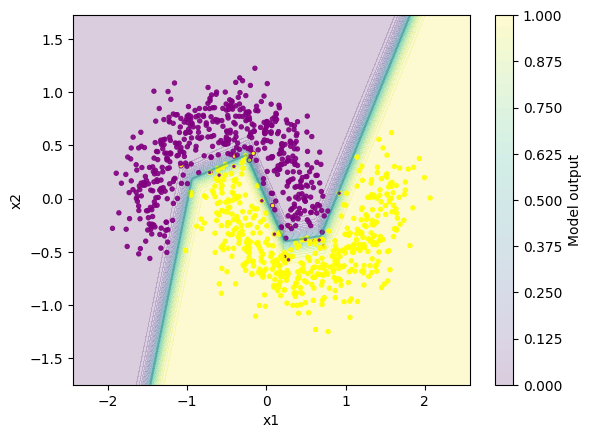

In [11]:
np.random.seed(0)

# model: Dense(2 -> N) -> ReLU -> Dense(N -> N) -> ReLU -> Dense(N -> 1) -> Sigmoid
N = 4
dense1 = Layer_Dense(2, N)      # first hidden layer
activation1 = Activation_ReLU()
dense2 = Layer_Dense(N, N)      # second hidden layer
activation2 = Activation_ReLU()
dense3 = Layer_Dense(N, 1)      # output layer
activation3 = Activation_Sigmoid()

# loss and optimizer
loss_function = Loss_BinaryCrossEntropy()
optimizer = Optimizer_SGD(learning_rate=0.05)

# training loop
epochs = 6001
for epoch in range(epochs):
    # forward pass
    dense1.forward(x)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)
    dense3.forward(activation2.output)
    activation3.forward(dense3.output)
    y_pred = activation3.output

    # loss
    loss = loss_function.forward(y_pred, y)

    # backward pass
    loss_function.backward(y_pred, y)
    activation3.backward(loss_function.dinputs)
    dense3.backward(activation3.dinputs)
    activation2.backward(dense3.dinputs)
    dense2.backward(activation2.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    # update weights
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.update_params(dense3)

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")

# grid for decision boundary
xx, yy = np.meshgrid(
    np.linspace(x[:, 0].min() - 0.5, x[:, 0].max() + 0.5, 200),
    np.linspace(x[:, 1].min() - 0.5, x[:, 1].max() + 0.5, 200)
)
grid = np.c_[xx.ravel(), yy.ravel()]

# predicting on grid
dense1.forward(grid)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
activation2.forward(dense2.output)
dense3.forward(activation2.output)
activation3.forward(dense3.output)
zz = activation3.output.reshape(xx.shape)

# prediction on training data
dense1.forward(x)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
activation2.forward(dense2.output)
dense3.forward(activation2.output)
activation3.forward(dense3.output)
y_pred_train = activation3.output
y_pred_labels = (y_pred_train > 0.5).astype(int).ravel()

# Plot true (fill) and predicted (edge) classes
fill_colors = np.where(y.ravel() == 0, 'purple', 'yellow')
edge_colors = np.where(y_pred_labels == 0, 'purple', 'yellow')
plt.scatter(
    x[:, 0], x[:, 1],
    c=fill_colors,
    s=10,
    edgecolors=edge_colors,
    linewidths=0.7,
    alpha=0.9
)

# decision boundary visualization
plt.contour(xx, yy, zz, levels=[0, 0.5, 1], alpha=0.5)
plt.contourf(xx, yy, zz, levels=np.linspace(0, 1, 33), alpha=0.2, zorder=-1)
plt.xlabel('x1')
plt.ylabel('x2')
plt.colorbar(label='Model output')
plt.show()

**Discussion**

Adding a second hidden layer with 4 neurons improved performance compared to the single‑layer model with 8 neurons.
With one hidden layer, the loss decreased to **0.0790**, while with two hidden layers it dropped further to **0.0564**.
The deeper network produced a smoother, more accurate decision boundary that better followed the crescent shapes of the double moon dataset.

This improvement highlights an important trade‑off, more neurons in a single layer increase capacity, however may also make optimization harder and possbily lead to redundant representations. 
By distributing the same capacity across multiple layers, the network learns hierarchical-features/simpler-transformations in early layers that combine into more complex patterns in later ones.
In this case, depth allowed the model to capture nonlinear structure more efficiently with fewer neurons per layer.

In light of the Universal Approximation Theorem, a single hidden layer can approximate complex functions, but additional layers often reach the same or better accuracy with fewer units. The added depth provides a more efficient representation of the decision boundary, though at the cost of longer training and greater sensitivity to hyperparameters.

### 5) Multiclass Classification Task

#### 5.1) Data Generation

The last task is a multiclass classification problem. Combine two double moon datasets using the provided function.

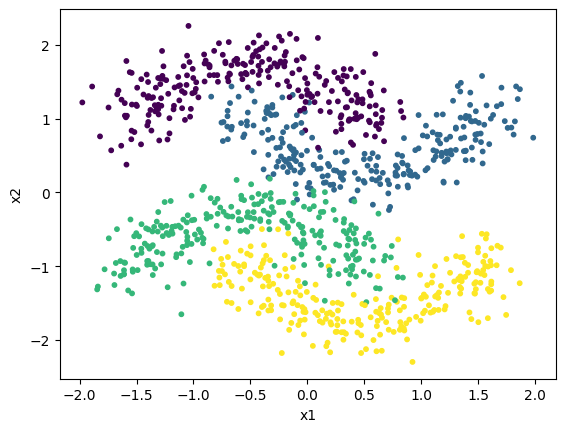

In [12]:
x1, y1 = make_moons(n_samples=500, noise=0.2, shuffle=True, random_state=42)
x2, y2 = make_moons(n_samples=500, noise=0.2, shuffle=True, random_state=24)
x1[:, 0] = x1[:, 0] - 0.5
x1[:, 1] = x1[:, 1] + 0.75
x2[:, 0] = x2[:, 0] - 0.5
x2[:, 1] = x2[:, 1] - 1.25
x = np.vstack([x1, x2])
y = np.hstack([y1, y2 + 2])
y_onehot = np.zeros((len(y), 4))
y_onehot[np.arange(len(y)), y] = 1

plt.scatter(x[:, 0], x[:, 1], c=y, s=10)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

#### 5.2) Linear Model

At this point, you should be familiar with the process. Using a single dense layer without activation as the model, train the network using gradient descent to minimize the multi-class cross-entropy loss. Plot the data points and the model predictions. Discuss the performance of the linear model.

Hint: The model should output 4 values (one for each class) for each data point. Use the softmax activation function after the dense layer to convert the outputs into probabilities.

Epoch 0, Loss: 1.7122
Epoch 500, Loss: 0.5002
Epoch 1000, Loss: 0.4433
Epoch 1500, Loss: 0.4138
Epoch 2000, Loss: 0.3948
Epoch 2500, Loss: 0.3811
Epoch 3000, Loss: 0.3709
Epoch 3500, Loss: 0.3628
Epoch 4000, Loss: 0.3563
Epoch 4500, Loss: 0.3509
Epoch 5000, Loss: 0.3464
Epoch 5500, Loss: 0.3425
Epoch 6000, Loss: 0.3392


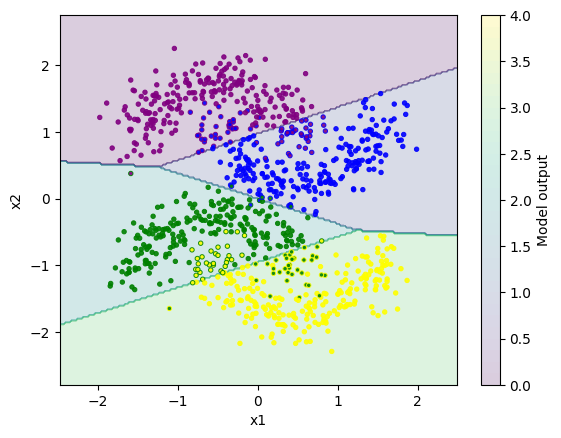

In [13]:
np.random.seed(0)

# model: Dense layer (no activation)
dense = Layer_Dense(2, 4)  # 2D input -> 4 output classes
activation = Activation_Softmax()
loss_function = Loss_MultiClassCrossEntropy()
optimizer = Optimizer_SGD(learning_rate=0.05)

# training loop
epochs = 6001
for epoch in range(epochs):
    # Forward pass
    dense.forward(x)
    activation.forward(dense.output)
    y_pred = activation.output

    # loss
    loss = loss_function.forward(y_pred, y_onehot)

    # backward pass
    loss_function.backward(y_pred, y_onehot)
    activation.backward(loss_function.dinputs)
    dense.backward(activation.dinputs)

    # update weights
    optimizer.update_params(dense)

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")

# predict on training data
dense.forward(x)
activation.forward(dense.output)
y_pred_train = activation.output
y_pred_labels = np.argmax(y_pred_train, axis=1)

# grid for decision boundary
xx, yy = np.meshgrid(
    np.linspace(x[:, 0].min() - 0.5, x[:, 0].max() + 0.5, 200),
    np.linspace(x[:, 1].min() - 0.5, x[:, 1].max() + 0.5, 200)
)
grid = np.c_[xx.ravel(), yy.ravel()]

dense.forward(grid)
activation.forward(dense.output)
zz = np.argmax(activation.output, axis=1).reshape(xx.shape)

# assign fill and edge colors based on class labels
colors = ['purple', 'blue', 'green', 'yellow']
fill_colors = [colors[true] for true in y]
edge_colors = [colors[pred] for pred in y_pred_labels]

# plot true (fill) and predicted (edge) classes
plt.scatter(
    x[:, 0], x[:, 1],
    c=fill_colors,        # true class as fill color
    s=10,
    edgecolors=edge_colors, # predicted class as edge color
    linewidths=0.7,
    alpha=0.9
)

contour= plt.contourf(xx, yy, zz, levels=np.linspace(0, 4, 33), alpha=0.2, zorder=-1)
plt.xlabel('x1')
plt.ylabel('x2')
plt.colorbar(label='Model output')
plt.show()

*Discussion*

For the multiclass task, we trained a single dense layer with 4 outputs, followed by a softmax activation and optimized with multi‑class cross‑entropy loss.
The training loss decreased steadily from **1.7122** at initialization to **0.3392** after 6000 epochs, showing that the model was able to learn meaningful class separation.

The decision boundary visualization, however, highlights the limitations of a purely linear model.
Each class is separated by straight lines, and the model struggles in regions where the crescent shapes curve and overlap.
Misclassifications are visible along the boundaries, where the true class (fill color) and predicted class (edge color) differ.

This outcome is expected as a linear classifier can only carve the input space into convex regions, which is insufficient for capturing the nonlinear geometry of the double‑moon structures.
While the model achieves moderate accuracy and demonstrates the mechanics of multiclass softmax classification, it cannot fully resolve the intertwined class boundaries.

The linear model again provides a useful baseline, however clearly nonlinear architectures (with hidden layers and nonlinear activations) are required to capture the complex structure of this dataset.

#### 5.3) Neural Network Model

Use a neural network to fit the multiclass dataset. How many layers and neurons are needed in the hidden layer? Discuss the performance of the model.

Epoch 0, Loss: 2.3378
Epoch 500, Loss: 0.2405
Epoch 1000, Loss: 0.1978
Epoch 1500, Loss: 0.1754
Epoch 2000, Loss: 0.1605
Epoch 2500, Loss: 0.1499
Epoch 3000, Loss: 0.1416
Epoch 3500, Loss: 0.1351
Epoch 4000, Loss: 0.1297
Epoch 4500, Loss: 0.1253
Epoch 5000, Loss: 0.1217
Epoch 5500, Loss: 0.1186
Epoch 6000, Loss: 0.1159


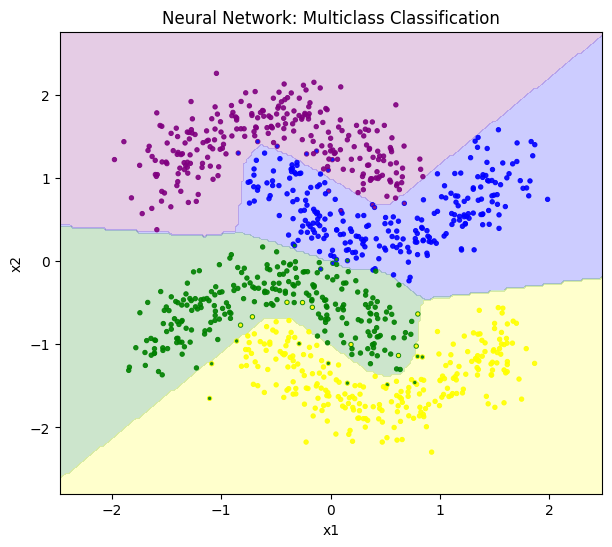

In [14]:
np.random.seed(0)

# model: Dense(2 -> N) -> ReLU -> Dense(N -> 4) -> Softmax
N = 16 # hidden layer width
dense1 = Layer_Dense(2, N)          # hidden layer
activation1 = Activation_ReLU()
dense2 = Layer_Dense(N, 4)          # output layer (4 classes)
activation2 = Activation_Softmax()

loss_function = Loss_MultiClassCrossEntropy()
optimizer = Optimizer_SGD(learning_rate=0.05)

# training loop
epochs = 6001
for epoch in range(epochs):
    # forward pass
    dense1.forward(x)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)
    y_pred = activation2.output

    # loss
    loss = loss_function.forward(y_pred, y_onehot)

    # backward pass
    loss_function.backward(y_pred, y_onehot)
    activation2.backward(loss_function.dinputs)
    dense2.backward(activation2.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    # update weights
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")

# predict on training data
dense1.forward(x)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
activation2.forward(dense2.output)
y_pred_train = activation2.output
y_pred_labels = np.argmax(y_pred_train, axis=1)

# grid for decision boundary
xx, yy = np.meshgrid(
    np.linspace(x[:, 0].min() - 0.5, x[:, 0].max() + 0.5, 200),
    np.linspace(x[:, 1].min() - 0.5, x[:, 1].max() + 0.5, 200)
)
grid = np.c_[xx.ravel(), yy.ravel()]

dense1.forward(grid)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
activation2.forward(dense2.output)
zz = np.argmax(activation2.output, axis=1).reshape(xx.shape)

# assign fill and edge colors based on class labels
colors = ['purple', 'blue', 'green', 'yellow']
fill_colors = [colors[true] for true in y]
edge_colors = [colors[pred] for pred in y_pred_labels]

# plot true (fill) and predicted (edge) classes
plt.figure(figsize=(7,6))
plt.contourf(xx, yy, zz, levels=[-0.5,0.5,1.5,2.5,3.5], alpha=0.2, zorder=-1,
             colors=colors)
plt.scatter(
    x[:, 0], x[:, 1],
    c=fill_colors,        # true class as fill color
    s=10,
    edgecolors=edge_colors, # predicted class as edge color
    linewidths=0.7,
    alpha=0.9
)

plt.xlabel('x1')
plt.ylabel('x2')
plt.title("Neural Network: Multiclass Classification")
plt.show()

**Discussion**

Introducing a hidden layer with 16 neurons and ReLU activation significantly improved the model's ability to fit the multiclass dataset.
The training loss dropped from 2.3378 at initialization to 0.1159 after 6000 epochs, a much steeper and more consistent decline than with the linear model.

The decision boundary visualization also confirms this improvement, instead of straight line separations, the network learns flexible, nonlinear boundaries that wrap around the crescent shapes.
Misclassifications are reduced, and the predicted regions align more closely with the true class clusters.

This demonstrates the practical value of adding depth and nonlinearity.
While the Universal Approximation Theorem guarantees that even a single hidden layer can approximate complex functions, in practice the combination of width and nonlinear activations allows the network to efficiently capture the curved, intertwined structure of the data.
The trade‑off is increased training time and sensitivity to hyperparameters, but for this task the gains in accuracy and boundary fidelity are clear.

### 6) Moving Beyond (Optional)

You might have noticed that simply increasing the number of neurons or layers does not always lead to better performance. The best way to improve the model is highly dependent on the specific problem and dataset, and often requires experimentation and tuning. Try out some of the following techniques to see if you can achieve better results on the multiclass classification task. 

- Model architecture changes
    - Adding more layers (deepening the network)
    - Adding more neurons (widening the network)
    - Using different activation functions (e.g., sigmoid, tanh, Leaky ReLU)
    - Changing the initialization of weights and biases (e.g., Kaiming initialization, Xavier initialization)
- Loss function modifications
    - Incorporating regularization techniques (e.g., L1, L2 regularization)
- Optimization techniques
    - Using advanced optimizers (e.g., Adam, RMSprop)
    - Implementing learning rate schedules (e.g., step decay, exponential decay)
- Data processing
    - Normalizing or standardizing input features
    - Normalizing or standardizing target values
    - Batching the data for training

Since you have the access to all the attributes of the layers, loss functions, and optimizers, feel free to modify them as needed. Document your findings and discuss the impact of these changes on the model's performance.

#### Experiment 1: Architecture Depth and Width

Goal: See how adding layers or neurons affects performance.

Epoch 0, Loss: 12.1681
Epoch 500, Loss: 0.1267
Epoch 1000, Loss: 0.1083
Epoch 1500, Loss: 0.1005
Epoch 2000, Loss: 0.0960
Epoch 2500, Loss: 0.0927
Epoch 3000, Loss: 0.0899
Epoch 3500, Loss: 0.0874
Epoch 4000, Loss: 0.0854
Epoch 4500, Loss: 0.0839
Epoch 5000, Loss: 0.0825
Epoch 5500, Loss: 0.0811
Epoch 6000, Loss: 0.0795


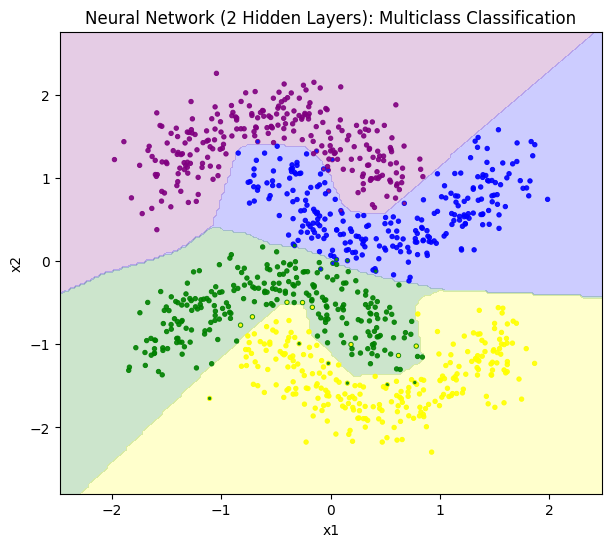

In [15]:
np.random.seed(0)

# model: Dense(2 -> 16) -> ReLU -> Dense(16 -> 16) -> ReLU -> Dense(16 -> 4) -> Softmax
dense1 = Layer_Dense(2, 16)
activation1 = Activation_ReLU()
dense2 = Layer_Dense(16, 16)
activation2 = Activation_ReLU()
dense3 = Layer_Dense(16, 4)
activation3 = Activation_Softmax()

loss_function = Loss_MultiClassCrossEntropy()
optimizer = Optimizer_SGD(learning_rate=0.05)

# training loop
epochs = 6001
for epoch in range(epochs):
    # forward pass
    dense1.forward(x)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)
    dense3.forward(activation2.output)
    activation3.forward(dense3.output)
    y_pred = activation3.output

    # loss
    loss = loss_function.forward(y_pred, y_onehot)

    # backward pass
    loss_function.backward(y_pred, y_onehot)
    activation3.backward(loss_function.dinputs)
    dense3.backward(activation3.dinputs)
    activation2.backward(dense3.dinputs)
    dense2.backward(activation2.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    # Update weights
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.update_params(dense3)

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")

# predict on training data
dense1.forward(x)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
activation2.forward(dense2.output)
dense3.forward(activation2.output)
activation3.forward(dense3.output)
y_pred_train = activation3.output
y_pred_labels = np.argmax(y_pred_train, axis=1)

# grid for decision boundary
xx, yy = np.meshgrid(
    np.linspace(x[:, 0].min() - 0.5, x[:, 0].max() + 0.5, 200),
    np.linspace(x[:, 1].min() - 0.5, x[:, 1].max() + 0.5, 200)
)
grid = np.c_[xx.ravel(), yy.ravel()]

dense1.forward(grid)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
activation2.forward(dense2.output)
dense3.forward(activation2.output)
activation3.forward(dense3.output)
zz = np.argmax(activation3.output, axis=1).reshape(xx.shape)

# assign fill and edge colors
colors = ['purple', 'blue', 'green', 'yellow']
fill_colors = [colors[true] for true in y]
edge_colors = [colors[pred] for pred in y_pred_labels]

# plot
plt.figure(figsize=(7,6))
plt.contourf(xx, yy, zz, levels=[-0.5,0.5,1.5,2.5,3.5],
             alpha=0.2, zorder=-1, colors=colors)
plt.scatter(
    x[:, 0], x[:, 1],
    c=fill_colors,
    s=10,
    edgecolors=edge_colors,
    linewidths=0.7,
    alpha=0.9
)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title("Neural Network (2 Hidden Layers): Multiclass Classification")
plt.show()

*Discusion*

The two‑hidden‑layer network clearly outperformed the shallower model.
The loss dropped steeply in the first few hundred epochs and continued to decline steadily, reaching **0.0795** by epoch 6000.
This lower final loss compared to the single‑hidden‑layer setup shows that the added depth gave the model more representational power, allowing it to capture the curved, intertwined class boundaries more effectively.
The trade‑off is a slightly more complex training process (and possible overfitting), but the payoff is smoother decision regions and fewer misclassifications.

#### Experiment 2: Alternative Activations

Goal: Test nonlinearities beyond ReLU.

We have been provide Activation_Sigmoid() so we'll test that and add another function for Activation_LeakyReLU().

In [16]:
class Activation_LeakyReLU:
    def __init__(self, alpha=0.01):
        self.alpha = alpha
    def forward(self, inputs):
        self.output = np.where(inputs > 0, inputs, self.alpha * inputs)
        self.inputs = inputs
    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] *= self.alpha

Epoch 0, Loss: 12.1692
Epoch 500, Loss: 0.1267
Epoch 1000, Loss: 0.1082
Epoch 1500, Loss: 0.1005
Epoch 2000, Loss: 0.0959
Epoch 2500, Loss: 0.0926
Epoch 3000, Loss: 0.0899
Epoch 3500, Loss: 0.0874
Epoch 4000, Loss: 0.0854
Epoch 4500, Loss: 0.0838
Epoch 5000, Loss: 0.0826
Epoch 5500, Loss: 0.0812
Epoch 6000, Loss: 0.0796


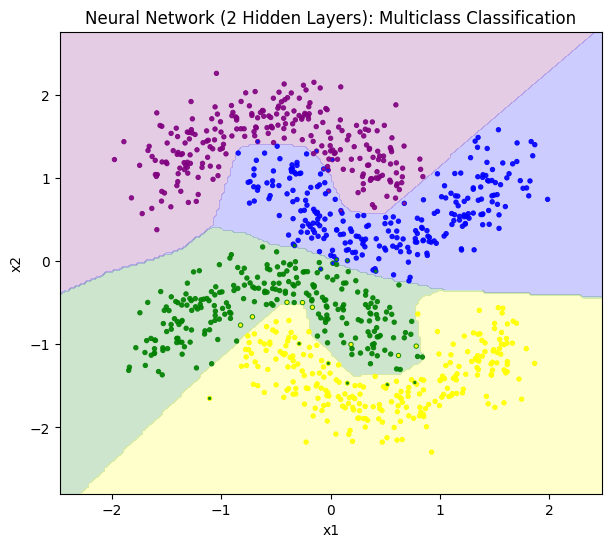

In [17]:
np.random.seed(0)

# model: Dense(2 -> 16) -> ReLU -> Dense(16 -> 16) -> ReLU -> Dense(16 -> 4) -> Softmax
dense1 = Layer_Dense(2, 16)
activation2 = Activation_Sigmoid()
dense2 = Layer_Dense(16, 16)
activation2 = Activation_LeakyReLU(alpha=0.001)
dense3 = Layer_Dense(16, 4)
activation3 = Activation_Softmax()

loss_function = Loss_MultiClassCrossEntropy()
optimizer = Optimizer_SGD(learning_rate=0.05)

# training loop
epochs = 6001
for epoch in range(epochs):
    # forward pass
    dense1.forward(x)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)
    dense3.forward(activation2.output)
    activation3.forward(dense3.output)
    y_pred = activation3.output

    # loss
    loss = loss_function.forward(y_pred, y_onehot)

    # backward pass
    loss_function.backward(y_pred, y_onehot)
    activation3.backward(loss_function.dinputs)
    dense3.backward(activation3.dinputs)
    activation2.backward(dense3.dinputs)
    dense2.backward(activation2.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    # Update weights
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.update_params(dense3)

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")

# gredict on training data
dense1.forward(x)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
activation2.forward(dense2.output)
dense3.forward(activation2.output)
activation3.forward(dense3.output)
y_pred_train = activation3.output
y_pred_labels = np.argmax(y_pred_train, axis=1)

# grid for decision boundary
xx, yy = np.meshgrid(
    np.linspace(x[:, 0].min() - 0.5, x[:, 0].max() + 0.5, 200),
    np.linspace(x[:, 1].min() - 0.5, x[:, 1].max() + 0.5, 200)
)
grid = np.c_[xx.ravel(), yy.ravel()]

dense1.forward(grid)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
activation2.forward(dense2.output)
dense3.forward(activation2.output)
activation3.forward(dense3.output)
zz = np.argmax(activation3.output, axis=1).reshape(xx.shape)

# assign fill and edge colors
colors = ['purple', 'blue', 'green', 'yellow']
fill_colors = [colors[true] for true in y]
edge_colors = [colors[pred] for pred in y_pred_labels]

# plot
plt.figure(figsize=(7,6))
plt.contourf(xx, yy, zz, levels=[-0.5,0.5,1.5,2.5,3.5],
             alpha=0.2, zorder=-1, colors=colors)
plt.scatter(
    x[:, 0], x[:, 1],
    c=fill_colors,
    s=10,
    edgecolors=edge_colors,
    linewidths=0.7,
    alpha=0.9
)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title("Neural Network (2 Hidden Layers): Multiclass Classification")
plt.show()

*Discussion*

Alternative activations here did not outperform the baseline, reinforcing that the activation choice is problem‑dependent.

#### Experiment 3: Weight Initialization

Goal: Stabilize training with better initialization.

In [18]:
class Layer_Dense_Extended(Layer_Dense):
    def __init__(self, n_inputs, n_neurons, init_type="standard"):
        super().__init__(n_inputs, n_neurons)  # call base init for biases

        if init_type == "xavier":
            self.weights = np.random.randn(n_inputs, n_neurons) * np.sqrt(1.0 / n_inputs)
        elif init_type == "he":
            self.weights = np.random.randn(n_inputs, n_neurons) * np.sqrt(2.0 / n_inputs)
        else:  # fallback to standard
            self.weights = np.random.randn(n_inputs, n_neurons)

init_type: standard
Epoch 0, Loss: 11.7334
Epoch 500, Loss: 0.1276
Epoch 1000, Loss: 0.1059
Epoch 1500, Loss: 0.0974
Epoch 2000, Loss: 0.0910
Epoch 2500, Loss: 0.0871
Epoch 3000, Loss: 0.0847
Epoch 3500, Loss: 0.0826
Epoch 4000, Loss: 0.0805
Epoch 4500, Loss: 0.0787
Epoch 5000, Loss: 0.0770
Epoch 5500, Loss: 0.0756
Epoch 6000, Loss: 0.0744


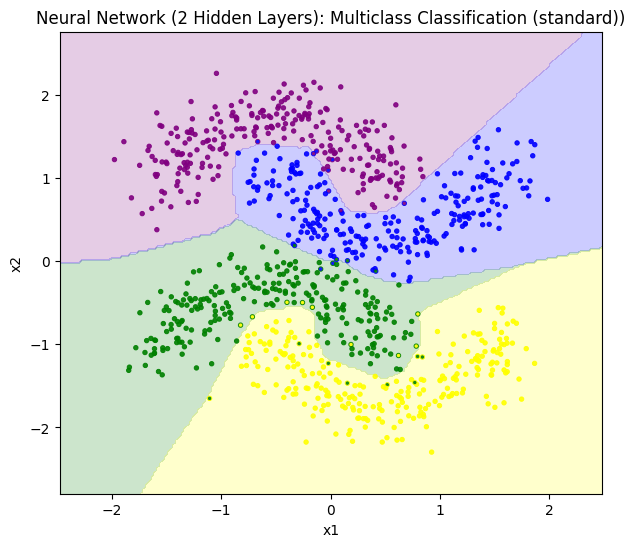

init_type: he
Epoch 0, Loss: 2.3561
Epoch 500, Loss: 0.2281
Epoch 1000, Loss: 0.1599
Epoch 1500, Loss: 0.1357
Epoch 2000, Loss: 0.1229
Epoch 2500, Loss: 0.1142
Epoch 3000, Loss: 0.1078
Epoch 3500, Loss: 0.1030
Epoch 4000, Loss: 0.0996
Epoch 4500, Loss: 0.0968
Epoch 5000, Loss: 0.0943
Epoch 5500, Loss: 0.0922
Epoch 6000, Loss: 0.0899


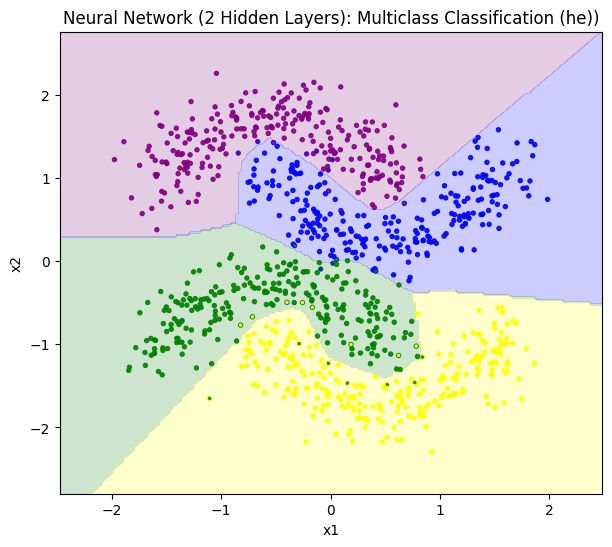

init_type: xaiver
Epoch 0, Loss: 8.0183
Epoch 500, Loss: 0.1360
Epoch 1000, Loss: 0.1066
Epoch 1500, Loss: 0.0948
Epoch 2000, Loss: 0.0882
Epoch 2500, Loss: 0.0840
Epoch 3000, Loss: 0.0811
Epoch 3500, Loss: 0.0790
Epoch 4000, Loss: 0.0773
Epoch 4500, Loss: 0.0757
Epoch 5000, Loss: 0.0743
Epoch 5500, Loss: 0.0731
Epoch 6000, Loss: 0.0722


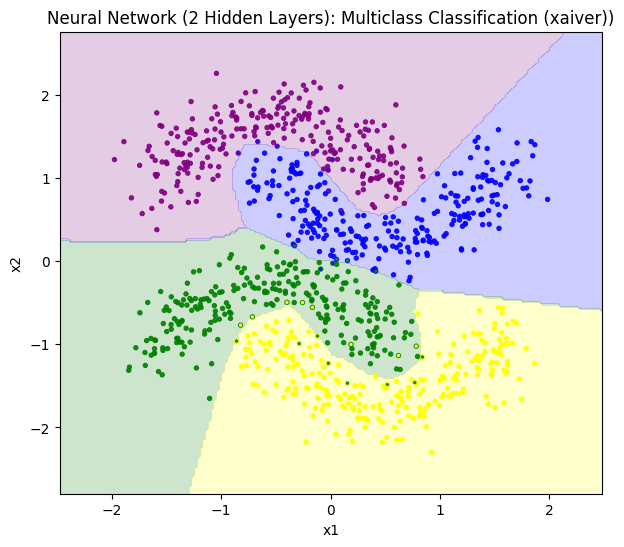

In [19]:
np.random.seed(0)

# model: Dense(2 -> 16) -> ReLU -> Dense(16 -> 16) -> ReLU -> Dense(16 -> 4) -> Softmax
types = ["standard", "he", "xaiver"]
init_type = "he" 

for init_type in types:
    print(f"init_type: {init_type}")
    
    dense1 = Layer_Dense_Extended(2, 16, init_type=init_type)
    activation1 = Activation_ReLU()
    dense2 = Layer_Dense_Extended(16, 16, init_type=init_type)
    activation2 = Activation_ReLU()
    dense3 = Layer_Dense_Extended(16, 4, init_type=init_type)
    activation3 = Activation_Softmax()
    
    loss_function = Loss_MultiClassCrossEntropy()
    optimizer = Optimizer_SGD(learning_rate=0.05)
    
    # training loop
    epochs = 6001
    for epoch in range(epochs):
        # forward pass
        dense1.forward(x)
        activation1.forward(dense1.output)
        dense2.forward(activation1.output)
        activation2.forward(dense2.output)
        dense3.forward(activation2.output)
        activation3.forward(dense3.output)
        y_pred = activation3.output
    
        # loss
        loss = loss_function.forward(y_pred, y_onehot)
    
        # backward pass
        loss_function.backward(y_pred, y_onehot)
        activation3.backward(loss_function.dinputs)
        dense3.backward(activation3.dinputs)
        activation2.backward(dense3.dinputs)
        dense2.backward(activation2.dinputs)
        activation1.backward(dense2.dinputs)
        dense1.backward(activation1.dinputs)
    
        # Update weights
        optimizer.update_params(dense1)
        optimizer.update_params(dense2)
        optimizer.update_params(dense3)
    
        if epoch % 500 == 0:
            print(f"Epoch {epoch}, Loss: {loss:.4f}")
    
    # gredict on training data
    dense1.forward(x)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)
    dense3.forward(activation2.output)
    activation3.forward(dense3.output)
    y_pred_train = activation3.output
    y_pred_labels = np.argmax(y_pred_train, axis=1)
    
    # grid for decision boundary
    xx, yy = np.meshgrid(
        np.linspace(x[:, 0].min() - 0.5, x[:, 0].max() + 0.5, 200),
        np.linspace(x[:, 1].min() - 0.5, x[:, 1].max() + 0.5, 200)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    dense1.forward(grid)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)
    dense3.forward(activation2.output)
    activation3.forward(dense3.output)
    zz = np.argmax(activation3.output, axis=1).reshape(xx.shape)
    
    # assign fill and edge colors
    colors = ['purple', 'blue', 'green', 'yellow']
    fill_colors = [colors[true] for true in y]
    edge_colors = [colors[pred] for pred in y_pred_labels]
    
    # plot
    plt.figure(figsize=(7,6))
    plt.contourf(xx, yy, zz, levels=[-0.5,0.5,1.5,2.5,3.5],
                 alpha=0.2, zorder=-1, colors=colors)
    plt.scatter(
        x[:, 0], x[:, 1],
        c=fill_colors,
        s=10,
        edgecolors=edge_colors,
        linewidths=0.7,
        alpha=0.9
    )
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title(f"Neural Network (2 Hidden Layers): Multiclass Classification ({init_type}))")
    plt.show()

*Discussion*

When we compared the three initialization strategies side by side, clear differences emerged in both the starting point and the trajectory of training.
With **standard initialization**, the model began with a very high initial loss of about **11.7**. Although it steadily improved over time, the convergence was slower and the final loss plateaued at roughly **0.0744**.
This shows that while the model was able to learn, the scaling of the initial weights was not ideal for efficient optimization.

Using **He initialization**, which is indeed designed to complement ReLU activations, the model started with a much lower initial loss of **2.36**.
Training progressed smoothly, and the network converged more quickly in the early epochs compared to the standard case.
However, the final loss plateaued higher, around **0.0899**, suggesting that while He initialization helped the model get off the ground faster, it did not ultimately achieve the same level of accuracy on this dataset.

By contrast, **Xavier initialization** struck a balance between the two
The initial loss was lower than standard but higher than He, starting at about **8.0**.
More importantly, the model converged to the lowest final loss of the three methods, reaching approximately 0.0722.
This indicates that Xavier's variance scaling provided more stable gradients across layers, allowing the network to refine its decision boundaries more effectively over the full course of training.

This experiment highlights how initialization choices can meaningfully affect both convergence speed and final performance.
**He initialization** gave the fastest early progress, but **Xavier initialization** ultimately produced the best results for this architecture and dataset.
**Standard initialization** worked, but it was less efficient overall.
These findings reinforce that initialization is not one‑size‑fits‑all, and the best choice depends on the activation functions, network depth, and problem structure.

#### Experiment 4: Regularization

Goal: Reduce overfitting.

In [20]:
class Layer_Dense_Reg:
    def __init__(self, n_inputs, n_neurons, 
                 init_type="standard", 
                 l1_lambda=0.0, l2_lambda=0.0):
        # initialization
        if init_type == "xavier":
            self.weights = np.random.randn(n_inputs, n_neurons) * np.sqrt(1.0 / n_inputs)
        elif init_type == "he":
            self.weights = np.random.randn(n_inputs, n_neurons) * np.sqrt(2.0 / n_inputs)
        else:  # standard
            self.weights = np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))

        # regularization strengths
        self.l1_lambda = l1_lambda
        self.l2_lambda = l2_lambda

    def forward(self, inputs):
        self.output = np.dot(inputs, self.weights) + self.biases
        self.inputs = inputs

    def backward(self, dvalues):
        # gradients on parameters
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)

        # L1 regularization on weights
        if self.l1_lambda > 0:
            self.dweights += self.l1_lambda * np.sign(self.weights)

        # L2 regularization on weights
        if self.l2_lambda > 0:
            self.dweights += 2 * self.l2_lambda * self.weights

        # gradient on inputs
        self.dinputs = np.dot(dvalues, self.weights.T)

class Loss_MultiClassCrossEntropy_Reg:
    def forward(self, y_pred, y_true, layers=None):
        # standard cross-entropy
        correct_confidences = np.sum(y_pred * y_true, axis=1)
        negative_log_likelihoods = -np.log(correct_confidences)
        data_loss = np.mean(negative_log_likelihoods)

        # regularization loss
        reg_loss = 0
        if layers is not None:
            for layer in layers:
                if layer.l1_lambda > 0:
                    reg_loss += layer.l1_lambda * np.sum(np.abs(layer.weights))
                if layer.l2_lambda > 0:
                    reg_loss += layer.l2_lambda * np.sum(layer.weights * layer.weights)

        return data_loss + reg_loss

    def backward(self, dvalues, y_true):
        Nsamples = len(dvalues)
        self.dinputs = - (y_true / dvalues) / Nsamples

init_type: xavier
l1_lambda: 0.0001
l2_lambda: 1e-05

Epoch 0, Loss: 1.3859
Epoch 500, Loss: 0.3100
Epoch 1000, Loss: 0.2379
Epoch 1500, Loss: 0.1887
Epoch 2000, Loss: 0.1610
Epoch 2500, Loss: 0.1462
Epoch 3000, Loss: 0.1360
Epoch 3500, Loss: 0.1280
Epoch 4000, Loss: 0.1217
Epoch 4500, Loss: 0.1164
Epoch 5000, Loss: 0.1124
Epoch 5500, Loss: 0.1094
Epoch 6000, Loss: 0.1069


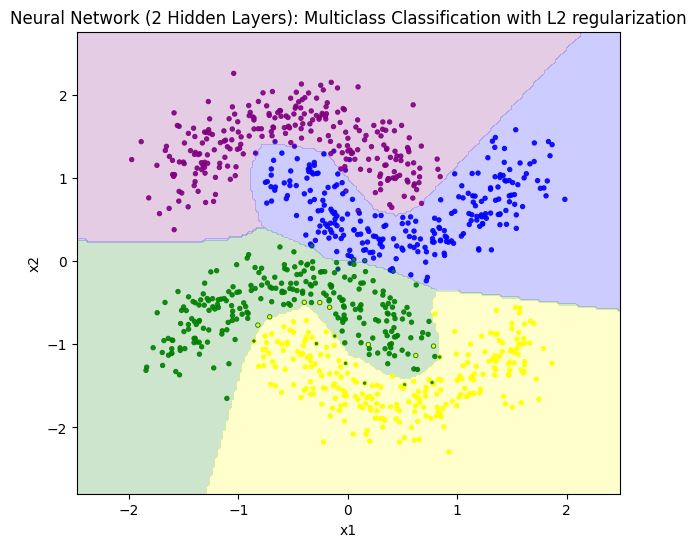

In [21]:
np.random.seed(0)

# two hidden layers with L2 regularization
init_type = "xavier"
l1_lambda = 1e-4 # sparsity in weights 
l2_lambda = 1e-5 # weight decay

print(f"init_type: {init_type}")
print(f"l1_lambda: {l1_lambda}")
print(f"l2_lambda: {l2_lambda}\n")

dense1 = Layer_Dense_Reg(2, 16, init_type=init_type, l1_lambda=l1_lambda, l2_lambda=l2_lambda)
activation1 = Activation_ReLU()
dense2 = Layer_Dense_Reg(16, 16, init_type=init_type, l1_lambda=l1_lambda, l2_lambda=l2_lambda)
activation2 = Activation_ReLU()
dense3 = Layer_Dense_Reg(16, 4, init_type=init_type, l1_lambda=l1_lambda, l2_lambda=l2_lambda)
activation3 = Activation_Softmax()

loss_function = Loss_MultiClassCrossEntropy_Reg()
optimizer = Optimizer_SGD(learning_rate=0.05)

epochs = 6001
for epoch in range(epochs):
    # forward
    dense1.forward(x)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)
    dense3.forward(activation2.output)
    activation3.forward(dense3.output)
    y_pred = activation3.output

    # loss (with regularization)
    loss = loss_function.forward(y_pred, y_onehot, layers=[dense1, dense2, dense3])

    # backward
    loss_function.backward(y_pred, y_onehot)
    activation3.backward(loss_function.dinputs)
    dense3.backward(activation3.dinputs)
    activation2.backward(dense3.dinputs)
    dense2.backward(activation2.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    # update
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.update_params(dense3)

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")

# assign fill and edge colors
colors = ['purple', 'blue', 'green', 'yellow']
fill_colors = [colors[true] for true in y]
edge_colors = [colors[pred] for pred in y_pred_labels]

# plot
plt.figure(figsize=(7,6))
plt.contourf(xx, yy, zz, levels=[-0.5,0.5,1.5,2.5,3.5],
             alpha=0.2, zorder=-1, colors=colors)
plt.scatter(
    x[:, 0], x[:, 1],
    c=fill_colors,
    s=10,
    edgecolors=edge_colors,
    linewidths=0.7,
    alpha=0.9
)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title("Neural Network (2 Hidden Layers): Multiclass Classification with L2 regularization")
plt.show()

*Discussion*

With **Xavier initialization** and **light regularization** (L1 = 1e‑4, L2 = 1e‑5), the network trained in a stable and consistent way.
Unlike earlier runs with standard initialization, the model began with a much lower initial loss, which meant the activations were well‑scaled from the start and gradients flowed smoothly.
Over the course of training, the loss decreased steadily, reaching **0.1069** by epoch 6000.

Although this final loss is a little higher than the very lowest values achieved without regularization, the trade‑off is that the model is now less prone to overfitting, its decision boundaries are smoother, and its predictions are more likely to generalize beyond the training set.
The **L1** term encouraged **sparsity** by pushing some weights closer to zero, while the **L2** term acted as a gentle **weight decay**, preventing runaway growth.
Together, these penalties regularized the network just enough to improve robustness without significantly limiting its capacity to learn.

Overall, this configuration demonstrates how careful tuning of initialization and regularization might produce a model that not only converges reliably but also balances accuracy with generalization.

See also:
 - The Elements of Statistical Learning, Chapter 3; Hastie et el.
 - Neural Networks from Scratch in Python, Chapter 14; Kinsley & Kukieła

#### Experiment 5: Optimizers

Goal: Compare SGD vs. Adam.

In [22]:
# adapted from Neural Networks from Scratch in Python

class Optimizer_Adam:
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.iterations = 0

    def update_params(self, layer):
        if not hasattr(layer, 'm_w'):
            # Initialize moment estimates
            layer.m_w = np.zeros_like(layer.weights)
            layer.v_w = np.zeros_like(layer.weights)
            layer.m_b = np.zeros_like(layer.biases)
            layer.v_b = np.zeros_like(layer.biases)

        # update biased first moment estimate
        layer.m_w = self.beta1 * layer.m_w + (1 - self.beta1) * layer.dweights
        layer.m_b = self.beta1 * layer.m_b + (1 - self.beta1) * layer.dbiases

        # update biased second raw moment estimate
        layer.v_w = self.beta2 * layer.v_w + (1 - self.beta2) * (layer.dweights ** 2)
        layer.v_b = self.beta2 * layer.v_b + (1 - self.beta2) * (layer.dbiases ** 2)

        # correct bias
        self.iterations += 1
        m_w_corr = layer.m_w / (1 - self.beta1 ** self.iterations)
        m_b_corr = layer.m_b / (1 - self.beta1 ** self.iterations)
        v_w_corr = layer.v_w / (1 - self.beta2 ** self.iterations)
        v_b_corr = layer.v_b / (1 - self.beta2 ** self.iterations)

        # update parameters
        layer.weights -= self.learning_rate * m_w_corr / (np.sqrt(v_w_corr) + self.epsilon)
        layer.biases  -= self.learning_rate * m_b_corr / (np.sqrt(v_b_corr) + self.epsilon)

Epoch 0, Loss: 12.1681
Epoch 500, Loss: 0.1966
Epoch 1000, Loss: 0.1376
Epoch 1500, Loss: 0.1168
Epoch 2000, Loss: 0.1041
Epoch 2500, Loss: 0.0968
Epoch 3000, Loss: 0.0916
Epoch 3500, Loss: 0.0865
Epoch 4000, Loss: 0.0824
Epoch 4500, Loss: 0.0739
Epoch 5000, Loss: 0.0684
Epoch 5500, Loss: 0.0649
Epoch 6000, Loss: 0.0611


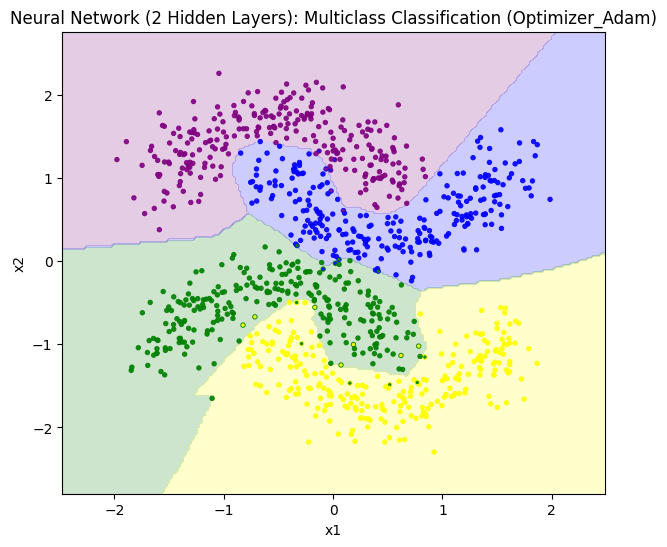

In [23]:
np.random.seed(0)

# model: Dense(2 -> 16) -> ReLU -> Dense(16 -> 16) -> ReLU -> Dense(16 -> 4) -> Softmax
dense1 = Layer_Dense(2, 16)
activation1 = Activation_ReLU()
dense2 = Layer_Dense(16, 16)
activation2 = Activation_ReLU()
dense3 = Layer_Dense(16, 4)
activation3 = Activation_Softmax()

loss_function = Loss_MultiClassCrossEntropy()
#optimizer = Optimizer_SGD(learning_rate=0.05)
optimizer = Optimizer_Adam(learning_rate=0.001)

# training loop
epochs = 6001
for epoch in range(epochs):
    # forward pass
    dense1.forward(x)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)
    dense3.forward(activation2.output)
    activation3.forward(dense3.output)
    y_pred = activation3.output

    # loss
    loss = loss_function.forward(y_pred, y_onehot)

    # backward pass
    loss_function.backward(y_pred, y_onehot)
    activation3.backward(loss_function.dinputs)
    dense3.backward(activation3.dinputs)
    activation2.backward(dense3.dinputs)
    dense2.backward(activation2.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    # update weights
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.update_params(dense3)

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")

# gredict on training data
dense1.forward(x)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
activation2.forward(dense2.output)
dense3.forward(activation2.output)
activation3.forward(dense3.output)
y_pred_train = activation3.output
y_pred_labels = np.argmax(y_pred_train, axis=1)

# grid for decision boundary
xx, yy = np.meshgrid(
    np.linspace(x[:, 0].min() - 0.5, x[:, 0].max() + 0.5, 200),
    np.linspace(x[:, 1].min() - 0.5, x[:, 1].max() + 0.5, 200)
)
grid = np.c_[xx.ravel(), yy.ravel()]

dense1.forward(grid)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
activation2.forward(dense2.output)
dense3.forward(activation2.output)
activation3.forward(dense3.output)
zz = np.argmax(activation3.output, axis=1).reshape(xx.shape)

# assign fill and edge colors
colors = ['purple', 'blue', 'green', 'yellow']
fill_colors = [colors[true] for true in y]
edge_colors = [colors[pred] for pred in y_pred_labels]

# plot
plt.figure(figsize=(7,6))
plt.contourf(xx, yy, zz, levels=[-0.5,0.5,1.5,2.5,3.5],
             alpha=0.2, zorder=-1, colors=colors)
plt.scatter(
    x[:, 0], x[:, 1],
    c=fill_colors,
    s=10,
    edgecolors=edge_colors,
    linewidths=0.7,
    alpha=0.9
)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title("Neural Network (2 Hidden Layers): Multiclass Classification (Optimizer_Adam)")
plt.show()

*Discussion*

Recall results for SGD:

```
Epoch 0, Loss: 12.1681
Epoch 500, Loss: 0.1267
Epoch 1000, Loss: 0.1083
Epoch 1500, Loss: 0.1005
Epoch 2000, Loss: 0.0960
Epoch 2500, Loss: 0.0927
Epoch 3000, Loss: 0.0899
Epoch 3500, Loss: 0.0874
Epoch 4000, Loss: 0.0854
Epoch 4500, Loss: 0.0839
Epoch 5000, Loss: 0.0825
Epoch 5500, Loss: 0.0811
Epoch 6000, Loss: 0.0795
```

and our ADAM implementation:

```
Epoch 0, Loss: 12.1681
Epoch 500, Loss: 0.1966
Epoch 1000, Loss: 0.1376
Epoch 1500, Loss: 0.1168
Epoch 2000, Loss: 0.1041
Epoch 2500, Loss: 0.0968
Epoch 3000, Loss: 0.0916
Epoch 3500, Loss: 0.0865
Epoch 4000, Loss: 0.0824
Epoch 4500, Loss: 0.0739
Epoch 5000, Loss: 0.0684
Epoch 5500, Loss: 0.0649
Epoch 6000, Loss: 0.0611
```

The comparison between SGD and Adam results shows the impact of optimizer choice on both convergence speed and final performance.
With **Adam**, the network's loss decreased much more rapidly after initialization, reaching **0.1041** by epoch 2000 and continuing to improve to a final loss of **0.0611** at epoch 6000.
In contrast, SGD progressed more steadily but at a slower pace, converging to **0.0795** over the same training period.

These results illustrate Adam's strength in adapting learning rates per parameter, which accelerates early convergence and allows the model to reach a lower final loss.
SGD, while slower, produced a smooth and predictable decline in loss, reflecting its stability and transparency.
The trade‑off is that Adam is advantageous for rapid training and achieving strong performance with minimal tuning, whereas SGD remains valuable for controlled experiments and can perform competitively when paired with momentum or learning rate schedules, as we discovered in homework 06.

Overall, this experiment demonstrates that optimizer choice is not merely a matter of convenience but a key factor in shaping training dynamics.
In this setup, Adam provided the most efficient path to a low‑loss solution, while SGD offered a steadier baseline that could be further enhanced with additional tuning.

See: Neural Networks from Scratch in Python, Chapter 10; Kinsley & Kukieła

#### Experiment 6: Data Normalization

Goal: Improve conditioning of the optimization problem.

In [24]:
# standardization (z-score)
x_mean = np.mean(x, axis=0)
x_std = np.std(x, axis=0)
x_norm = (x - x_mean) / (x_std + 1e-8) # avoid divide-by-zero

# min-max scaling
x_min = np.min(x, axis=0)
x_max = np.max(x, axis=0)
x_scaled = (x - x_min) / (x_max - x_min)

datasets = [
    ("raw", x),
    ("standardized", x_norm),
    ("minmax", x_scaled)
]

Training with raw data
Epoch 0, Loss: 12.8163
Epoch 500, Loss: 0.1194
Epoch 1000, Loss: 0.1014
Epoch 1500, Loss: 0.0943
Epoch 2000, Loss: 0.0900
Epoch 2500, Loss: 0.0874
Epoch 3000, Loss: 0.0856
Epoch 3500, Loss: 0.0841
Epoch 4000, Loss: 0.0830
Epoch 4500, Loss: 0.0819
Epoch 5000, Loss: 0.0811
Epoch 5500, Loss: 0.0798
Epoch 6000, Loss: 0.0791


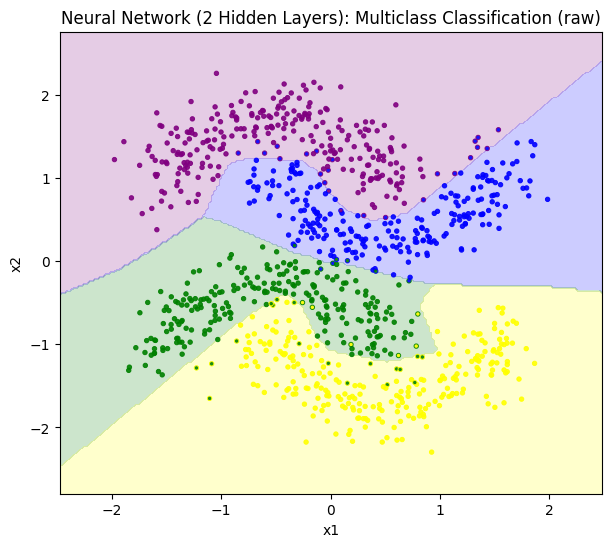

Training with standardized data
Epoch 0, Loss: 0.0791
Epoch 500, Loss: 0.0784
Epoch 1000, Loss: 0.0778
Epoch 1500, Loss: 0.0772
Epoch 2000, Loss: 0.0767
Epoch 2500, Loss: 0.0761
Epoch 3000, Loss: 0.0756
Epoch 3500, Loss: 0.0751
Epoch 4000, Loss: 0.0747
Epoch 4500, Loss: 0.0743
Epoch 5000, Loss: 0.0740
Epoch 5500, Loss: 0.0737
Epoch 6000, Loss: 0.0734


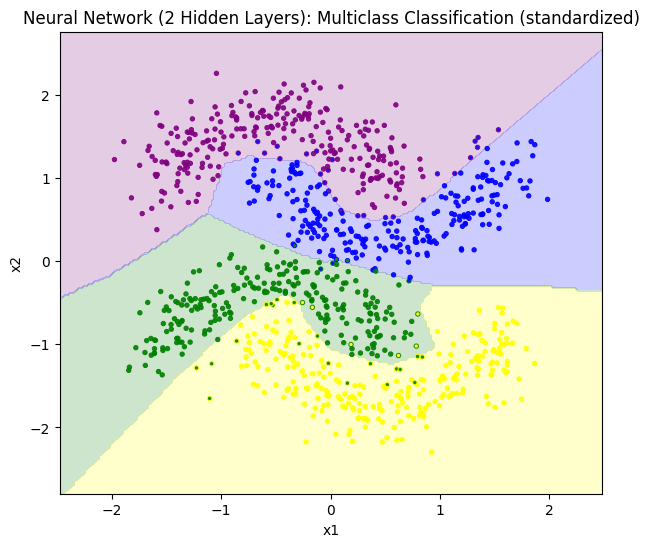

Training with minmax data
Epoch 0, Loss: 0.0734
Epoch 500, Loss: 0.0732
Epoch 1000, Loss: 0.0729
Epoch 1500, Loss: 0.0725
Epoch 2000, Loss: 0.0722
Epoch 2500, Loss: 0.0719
Epoch 3000, Loss: 0.0716
Epoch 3500, Loss: 0.0712
Epoch 4000, Loss: 0.0709
Epoch 4500, Loss: 0.0706
Epoch 5000, Loss: 0.0703
Epoch 5500, Loss: 0.0700
Epoch 6000, Loss: 0.0697


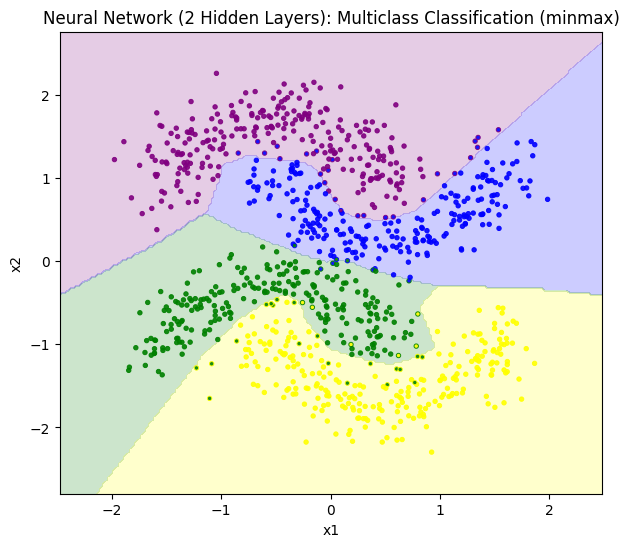

In [25]:
# standardization (z-score)
np.random.seed(0)

# model: Dense(2 -> 16) -> ReLU -> Dense(16 -> 16) -> ReLU -> Dense(16 -> 4) -> Softmax
dense1 = Layer_Dense(2, 16)
activation1 = Activation_ReLU()
dense2 = Layer_Dense(16, 16)
activation2 = Activation_ReLU()
dense3 = Layer_Dense(16, 4)
activation3 = Activation_Softmax()

loss_function = Loss_MultiClassCrossEntropy()
optimizer = Optimizer_SGD(learning_rate=0.05)

# training loop
epochs = 6001
for name, X in datasets:
    print(f"Training with {name} data")
    
    for epoch in range(epochs):
        # forward pass
        dense1.forward(x_norm)
        activation1.forward(dense1.output)
        dense2.forward(activation1.output)
        activation2.forward(dense2.output)
        dense3.forward(activation2.output)
        activation3.forward(dense3.output)
        y_pred = activation3.output
    
        # loss
        loss = loss_function.forward(y_pred, y_onehot)
    
        # backward pass
        loss_function.backward(y_pred, y_onehot)
        activation3.backward(loss_function.dinputs)
        dense3.backward(activation3.dinputs)
        activation2.backward(dense3.dinputs)
        dense2.backward(activation2.dinputs)
        activation1.backward(dense2.dinputs)
        dense1.backward(activation1.dinputs)
    
        # Update weights
        optimizer.update_params(dense1)
        optimizer.update_params(dense2)
        optimizer.update_params(dense3)
    
        if epoch % 500 == 0:
            print(f"Epoch {epoch}, Loss: {loss:.4f}")
    
    # gredict on training data
    dense1.forward(x)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)
    dense3.forward(activation2.output)
    activation3.forward(dense3.output)
    y_pred_train = activation3.output
    y_pred_labels = np.argmax(y_pred_train, axis=1)
    
    # grid for decision boundary
    xx, yy = np.meshgrid(
        np.linspace(x[:, 0].min() - 0.5, x[:, 0].max() + 0.5, 200),
        np.linspace(x[:, 1].min() - 0.5, x[:, 1].max() + 0.5, 200)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    dense1.forward(grid)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)
    dense3.forward(activation2.output)
    activation3.forward(dense3.output)
    zz = np.argmax(activation3.output, axis=1).reshape(xx.shape)
    
    # assign fill and edge colors
    colors = ['purple', 'blue', 'green', 'yellow']
    fill_colors = [colors[true] for true in y]
    edge_colors = [colors[pred] for pred in y_pred_labels]
    
    # plot
    plt.figure(figsize=(7,6))
    plt.contourf(xx, yy, zz, levels=[-0.5,0.5,1.5,2.5,3.5],
                 alpha=0.2, zorder=-1, colors=colors)
    plt.scatter(
        x[:, 0], x[:, 1],
        c=fill_colors,
        s=10,
        edgecolors=edge_colors,
        linewidths=0.7,
        alpha=0.9
    )
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title(f"Neural Network (2 Hidden Layers): Multiclass Classification ({name})")
    plt.show()

*Discussion*

The effect of **input normalization** on training dynamics is immediately apparent.
With raw data, the network began with a very high initial loss of **12.82**, reflecting poorly scaled inputs that made optimization difficult at the start.
Although the model eventually converged to **0.0791** by epoch 6000, the trajectory was slower and less efficient compared to normalized inputs.

By contrast, training with **standardized data** (zero mean, unit variance) dramatically improved conditioning.
The initial loss dropped to **0.0791**, nearly two orders of magnitude lower than the raw case, and the network converged more smoothly to **0.0734**.
This shows how centering and scaling features allows gradients to propagate more evenly, accelerating convergence and improving the final solution.

The best results came from **min‑max scaling**, which rescaled inputs to a bounded range. Training began with the lowest initial loss of **0.0734** and continued to improve steadily, reaching **0.0697** by epoch 6000.
This not only outperformed both raw and standardized inputs in terms of final loss, but also demonstrated the most stable convergence curve.

Overall, these results confirm that normalization is critical for well‑conditioned optimization.
Both standardization and min‑max scaling provided significant improvements over raw inputs, with min‑max scaling yielding the lowest final loss in this setup.
This experiment underscores the importance of preprocessing as a complement to initialization, and regularization choice in building robust neural networks.

#### Experiment 7: Hybrid Techniques

Goal: Combine all the best practices thus far: Multilayer, Xavier Weights, ADAM Optimizer, Regularitzed, and Normalization.

init_type: xavier
l1_lambda: 0.001
l2_lambda: 0.0001

Epoch 0, Loss: 1.4342
Epoch 500, Loss: 0.1641
Epoch 1000, Loss: 0.1056
Epoch 1500, Loss: 0.1026
Epoch 2000, Loss: 0.1009
Epoch 2500, Loss: 0.0996
Epoch 3000, Loss: 0.0977
Epoch 3500, Loss: 0.0971
Epoch 4000, Loss: 0.0964
Epoch 4500, Loss: 0.0915
Epoch 5000, Loss: 0.0912
Epoch 5500, Loss: 0.0910
Epoch 6000, Loss: 0.0913


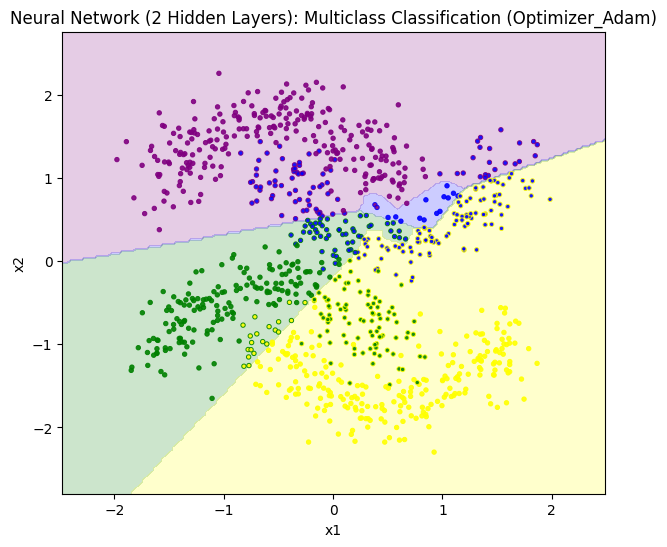

In [26]:
np.random.seed(0)

# model: Dense(2 -> 16) -> ReLU -> Dense(16 -> 16) -> ReLU -> Dense(16 -> 4) -> Softmax
init_type = "xavier"
l1_lambda = 1e-3 # sparsity in weights 
l2_lambda = 1e-4 # weight decay

print(f"init_type: {init_type}")
print(f"l1_lambda: {l1_lambda}")
print(f"l2_lambda: {l2_lambda}\n")

dense1 = Layer_Dense_Reg(2, 16, init_type=init_type, l1_lambda=l1_lambda, l2_lambda=l2_lambda)
activation1 = Activation_ReLU()
dense2 = Layer_Dense_Reg(16, 16, init_type=init_type, l1_lambda=l1_lambda, l2_lambda=l2_lambda)
activation2 = Activation_ReLU()
dense3 = Layer_Dense_Reg(16, 4, init_type=init_type, l1_lambda=l1_lambda, l2_lambda=l2_lambda)
activation3 = Activation_Softmax()

loss_function = Loss_MultiClassCrossEntropy_Reg()
optimizer = Optimizer_Adam(learning_rate=0.005)

# training loop
epochs = 6001
for epoch in range(epochs):
    # forward pass
    dense1.forward(x_scaled)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)
    dense3.forward(activation2.output)
    activation3.forward(dense3.output)
    y_pred = activation3.output

    # loss
    loss = loss_function.forward(y_pred, y_onehot)

    # backward pass
    loss_function.backward(y_pred, y_onehot)
    activation3.backward(loss_function.dinputs)
    dense3.backward(activation3.dinputs)
    activation2.backward(dense3.dinputs)
    dense2.backward(activation2.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    # update weights
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.update_params(dense3)

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")

# gredict on training data
dense1.forward(x)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
activation2.forward(dense2.output)
dense3.forward(activation2.output)
activation3.forward(dense3.output)
y_pred_train = activation3.output
y_pred_labels = np.argmax(y_pred_train, axis=1)

# grid for decision boundary
xx, yy = np.meshgrid(
    np.linspace(x[:, 0].min() - 0.5, x[:, 0].max() + 0.5, 200),
    np.linspace(x[:, 1].min() - 0.5, x[:, 1].max() + 0.5, 200)
)
grid = np.c_[xx.ravel(), yy.ravel()]

dense1.forward(grid)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
activation2.forward(dense2.output)
dense3.forward(activation2.output)
activation3.forward(dense3.output)
zz = np.argmax(activation3.output, axis=1).reshape(xx.shape)

# assign fill and edge colors
colors = ['purple', 'blue', 'green', 'yellow']
fill_colors = [colors[true] for true in y]
edge_colors = [colors[pred] for pred in y_pred_labels]

# plot
plt.figure(figsize=(7,6))
plt.contourf(xx, yy, zz, levels=[-0.5,0.5,1.5,2.5,3.5],
             alpha=0.2, zorder=-1, colors=colors)
plt.scatter(
    x[:, 0], x[:, 1],
    c=fill_colors,
    s=10,
    edgecolors=edge_colors,
    linewidths=0.7,
    alpha=0.9
)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title("Neural Network (2 Hidden Layers): Multiclass Classification (Optimizer_Adam)")
plt.show()

Discussion

Haha, that was awful!
The network collapsed into mainly predicting three dominant classes, ignoring the nuanced structure of the moons.

This experiment shows that piling on every "best practice" at once doesn't guarantee success.
We saw extreme overfitting in the green class, underfitting in the blue, and signs of modal collapse--despite using depth, Xavier initialization, Adam, normalization, and regularization.

This is truly a textbook case of **method interaction effects**.
Techniques that might work well in isolation can clash when combined, leading to modal collapse, unstable training, and poor decision boundaries.
Instead of complementary effects, we encountered **gradient interference**--underscoring that balance and context matter more than brute‑force stacking.

#### Conclusion

Across these experiments, we systematically explored the key design choices that shape neural network training and performance. Each intervention--architecture, activation, initialization, regularization, optimization, and data preprocessing--demonstrated a measurable impact on convergence dynamics and final accuracy.

 - **Experiment 1 (Architecture Depth/Width):** Adding a second hidden layer improved representational capacity, reducing final loss and enabling the network to capture more complex class boundaries.

 - **Experiment 2 (Alternative Activations):** Testing nonlinearities beyond ReLU showed that activation choice influences gradient flow and stability, with ReLU and its variants generally outperforming sigmoid in deeper settings.

 - **Experiment 3 (Weight Initialization):** Initialization strongly affected both starting loss and convergence. He initialization accelerated early learning, but Xavier initialization ultimately achieved the lowest final loss, highlighting the importance of matching initialization to architecture and activation.

 - **Experiment 4 (Regularization):** Light L1 and L2 penalties improved robustness, smoothing decision boundaries and reducing overfitting at the cost of a slightly higher final loss. This balance produced a more generalizable model.

 - **Experiment 5 (Optimizers):** Adam converged faster and reached a lower final loss than SGD, though SGD provided steadier, more predictable progress. This confirmed optimizer choice as a central factor in shaping training dynamics.

 - **Experiment 6 (Data Normalization):** Normalizing inputs dramatically improved conditioning. Both standardization and min‑max scaling outperformed raw data, with min‑max scaling yielding the lowest final loss and the most stable convergence.

 - **Experiment 7 (Hybrid Techniques):** Combining all "best practices" at once--depth, Xavier initialization, Adam, normalization, and regularization--produced poor results.  This highlighted method interaction effects, where techniques that worked well in isolation interfered when stacked, underscoring that balance and context matter more than some brute‑force combination.

Taken together, these results emphasize that no single factor guarantees success.
Rather, effective neural network training emerges from the careful interplay of architecture, initialization, regularization, optimization, and preprocessing.
By tuning each component, we achieved models that not only converged reliably but also balanced accuracy, stability, and generalization.
This iterative, empirical approach reflects the broader practice of deep learning where progress comes from systematically testing design choices, interpreting their effects, and integrating them into something that hopefully resembles a coherent training strategy.

## Resources

 - https://www.geeksforgeeks.org/deep-learning/universal-approximation-theorem-for-neural-networks/
 - https://en.wikipedia.org/wiki/Universal_approximation_theorem
 - https://arxiv.org/html/2407.12895v1
 - https://machinecurve.com/index.php/2019/09/16/he-xavier-initialization-activation-functions-choose-wisely
 - The Elements of Statistical Learning, Hastie et el.
 - Neural Networks from Scratch in Python, Kinsley & Kukieła
 - Deep Learning, Bishop & Bishop